# Random Forest implementation and evaluation:
***
### We start by loading libraries and the dataset
***

## NOTE: If run with full dataset this notebook takes 2-3 hours to run
***

In [1]:
# Loading R libraries [Install packages if necessary]

# install.packages("ROSE")
# install.packages("randomForest")
# install.packages('e1071', dependencies=TRUE)
# install.packages('caret', dependencies=TRUE)
library(ROSE)
library(randomForest)
library(caret)
library(e1071)

Loaded ROSE 0.0-4


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice



## These functions have been taken from Lab 4

In [23]:
# ************************************************
# getTreeClassifications() :
#
# Put in test dataset and get out class predictions of the decision tree
# Determine the threshold, plot the results and calculate metrics
#
# INPUT   :   object         - myTree       - tree
#         :   Data Frame     - testDataset  - dataset to evaluate
#         :   string         - title        - string to plot as the chart title
#         :   int            - classLabel   - lable given to the positive (TRUE) class
#         :   boolean        - plot         - TRUE to output results/charts
#
# OUTPUT  :   List       - Named evaluation measures
#
# ************************************************
getTreeClassifications<-function(myTree,
                                 testDataset,
                                 title,
                                 classLabel=1,
                                 plot=TRUE,
                                 OUTPUT_FIELD){

  positionClassOutput=which(names(testDataset)==OUTPUT_FIELD)

  #test data: dataframe with with just input fields
  test_inputs<-testDataset[-positionClassOutput]

  # Generate class membership probabilities
  # Column 1 is for class 0 (no disease) and column 2 is for class 1 (has disease)

  testPredictedClassProbs<-predict(myTree,test_inputs, type="prob")

  # Get the column index with the class label
  classIndex<-which(as.numeric(colnames(testPredictedClassProbs))==classLabel)

  # Get the probabilities for classifying the diseases
  test_predictedProbs<-testPredictedClassProbs[,classIndex]

  #test data: vector with just the expected output class
  test_expected<-testDataset[,positionClassOutput]

  measures<-NdetermineThreshold(test_expected=test_expected,
                                test_predicted=test_predictedProbs,
                                plot=plot,
                                title=title)

  #if (plot==TRUE)
    #NprintMeasures(results=measures,title=title)

  return(measures)

} #endof getTreeClassifications()

# ************************************************
# NEvaluateClassifier() :
#
# Use dataset to generate predictions from model
# Evaluate as classifier using threshold value
#
# INPUT   :   vector double     - probs        - probability of being class 1
#             Data Frame        - testing_data - Dataset to evaluate
#             double            - threshold     -cutoff (probability) for classification
#
# OUTPUT  :   List       - Named evaluation measures
#                        - Predicted class probability
#
# ************************************************
NEvaluateClassifier<-function(test_predicted,test_expected,threshold) {

  predictedClass<-ifelse(test_predicted<threshold,0,1)

  results<-NcalcConfusion(expectedClass=test_expected,
                          predictedClass=predictedClass)

  return(results)
} #endof NEvaluateClassifier()

NcalcConfusion<-function(expectedClass,predictedClass){

  confusion<-table(factor(predictedClass,levels=0:1),factor(expectedClass,levels=0:1))

  # This "converts" the above into our preferred format

  TP<-as.double(confusion[2,2])
  FN<-as.double(confusion[1,2])
  FP<-as.double(confusion[2,1])
  TN<-as.double(confusion[1,1])

  return(NcalcMeasures(TP,FN,FP,TN))

} #endof NcalcConfusion()

## NcalcMeasures has been modified from Lab 4 to calculate different metrics

In [24]:
NcalcMeasures <- function(TP,FN,FP,TN){
  npv    <-round((TN/(FN+TN)),digits=4) 
  fpr     <-round((FP/(FP+TN)),digits=4)
  tpr     <-round((TP/(TP+FN)),digits=4) # recall, sensitivity
  tnr     <-round((TN/(FP+TN)),digits=4) # specificity
  fnr     <-round((FN/(FN+TP)),digits=4) 
  threatScore    <-round((TP/(TP+FN+FP)),digits=4) #threat score and balanced accurary added
  balancedacc    <-round(((tpr+tnr)/2),digits=4)
    
    retList<-list("TP"=TP,
                  "FN"=FN,
                  "TN"=TN,
                  "FP"=FP,
                  "NPV"=npv,
                  "FPR"=fpr,
                  "TPR"=tpr,
                  "TNR"=tnr,
                  "FNR"=fnr,
                  "threatScore"=threatScore,
                  "balancedacc"=balancedacc
    )
    return(retList)
}

## NdetermineThreshold has been modified from Lab 4 to plot our desired metrics on the graphs

### parts not required are removed

In [25]:
# ************************************************
# NdetermineThreshold() :
#
# For the range of threholds [0,1] calculate a confusion matrix
# and classifier metrics.
# Deterime "best" threshold based on either distance or Youdan
# Plot threshold chart and ROC chart
#
# Plot the results
#
# INPUT   :   vector double  - test_predicted   - probability of being class 1
#         :   vector double  - test_expected    - dataset to evaluate
#         :   boolean        - plot             - TRUE=output charts
#         :   string         - title            - chart title
#
# OUTPUT  :   List       - Named evaluation measures from confusion matrix
#                        - Threshold at min Euclidean distance
#                        - AUC - area under the ROC curve
#                        - Predicted class probability
#
# 241019NRT - added plot flag and title for charts
# 311019NRT - added axis bound checks in abline plots
# 191020NRT - Updated to use own ROC plot & calculate AUC
# ************************************************
NdetermineThreshold<-function(test_predicted,
                              test_expected,
                              plot=TRUE,
                              title=""){
  toPlot<-data.frame()

  #Increment the threshold by 1% in a range of 0 to 1
  for(threshold in seq(0,1,by=0.01)){
    results<-NEvaluateClassifier(test_predicted=test_predicted,
                                  test_expected=test_expected,
                                  threshold=threshold)
    toPlot<-rbind(toPlot,data.frame(x=threshold,fpr=results$FPR,tpr=results$TPR, balancedacc=results$balancedacc, threatScore=results$threatScore, fnr=results$FNR))
  }

  # Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
  # To the top left (i.e. perfect classifier)
  toPlot$distance<-sqrt(((1-toPlot$tpr)^2)+((toPlot$fpr)^2))

  # 121020NRT - Euclidean distance to "perfect" classifier (smallest the best)
  # use which.min() to return a single index to the lowest value in the vector
  minEuclidean<-toPlot$x[which.min(toPlot$distance)]

  # ************************************************
  # Plot threshold graph

  if (plot==TRUE){
    ######### Sensitivity (TPR)
    plot(toPlot$x,toPlot$tpr,
         xlim=c(0, 1), ylim=c(0, 1), cex.lab=1.2,
         type="l",lwd=3, col="blue",
         xlab="Threshold",
         ylab="Metrics",
         main=paste("Threshold Perfomance Classifier Model",title))

    # Plot the specificity (1-FPR)
    lines(toPlot$x,1-toPlot$fpr,type="l",col="red",lwd=3,lty=1)
      
    # plot the threat score
    lines(toPlot$x,toPlot$threatScore,type="l",col="orange",lwd=3,lty=1)
      
    # plot the miss rate
    lines(toPlot$x,toPlot$fnr,type="l",col="purple",lwd=3,lty=1)
    
    # The point where specificity and sensitivity are the same
    crosspoint<-toPlot$x[which(toPlot$tpr<(1-toPlot$fpr))[1]]

    # Plot the Euclidean distance to "perfect" classifier (smallest the best)
    lines(toPlot$x,toPlot$distance,type="l",col="green",lwd=2,lty=3)

    # Plot the min distance, as might be more (311019NRT check it is within range)
    if ((minEuclidean<1) & (minEuclidean>0))
      abline(v=minEuclidean,col="green",lty=3,lwd=2)
      
    # set the legend - you can change position to "bottomright", "bottom", "bottomleft", "left",
    # "topleft", "top", "topright", "right" and "center" as per what your graph looks like
    legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),lty=1,lwd=2)
    text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

    # ************************************************
    # ROC graph
      
    balacc <- toPlot$balancedacc[which.min(toPlot$distance)]
    sensitivityROC<-toPlot$tpr[which.min(toPlot$distance)]
    specificityROC<-1-toPlot$fpr[which.min(toPlot$distance)]

    # Set origin point for plotting
    toPlot<-rbind(toPlot,data.frame(x=0,fpr=0,tpr=0 ,distance=0, threatScore=0, fnr=0, balancedacc=0))

    plot(1-toPlot$fpr,toPlot$tpr,type="l",lwd=3, col="black",
         main=paste("ROC:",title),
         cex.lab=1.2,
         xlab="Specificity (1-FPR)", 
         ylab="Sensitivity (TPR)",
         xlim=c(1,0),
         ylim=c(0,1)
    )

    axis(1, seq(0.0,1.0,0.1))
    axis(2, seq(0.0,1.0,0.1))

    #Add crosshairs to the graph
    abline(h=sensitivityROC,col="red",lty=3,lwd=2)
    abline(v=specificityROC,col="red",lty=3,lwd=2)

    annotate<-paste("Threshold: ",round(minEuclidean,digits=4L),
                    "\nBalanced Acc.: ",round(balacc,digits=4L),
                    "\nSensitivity: ",round(sensitivityROC,digits=2L),
                    "\nSpecificity: ",round(specificityROC,digits=2L),
                    sep="")

    text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1, col="red",annotate)

  } # endof if plotting

  # Select the threshold - I have choosen distance

  myThreshold<-minEuclidean      # Min Distance should be the same as analysis["threshold"]

  #Use the "best" distance threshold to evaluate classifier
  results<-NEvaluateClassifier(test_predicted=test_predicted,
                                test_expected=test_expected,
                                threshold=myThreshold)

  results$threshold<-myThreshold

 # view the results values for that particular threshold - you will need to add these to a table yourself after
 # repeating for all 8 diseases
  #print(results)
  return(results)

} #endof myPerformancePlot()

In [2]:
start_time <- Sys.time() #set the current time as start time for logging duration
#Load the smaller dataset from .csv file for hyperparameter tuning
#size is 10% of the original dataset
newDataset <- read.csv(file = 'brfssCleaned.csv')
head(newDataset) #display the top rows for checking

,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,⋯,ECIGARET,QSTVER,QSTLANG,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTM4,BMI5,DROCDY3_
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.25,0.1000000,1,1,1,0,1.00,0,0.1739130,⋯,0,0,0,0,0,0.0000000,0.5833333,0.5266667,0.05300312,0
2,1,0.50,0.0000000,0,0,0,0,0.25,0,0.2608696,⋯,1,0,0,0,0,0.1428571,0.7500000,0.4800000,0.19858813,0
3,1,0.50,0.0000000,0,0,0,1,0.25,0,0.2608696,⋯,1,0,0,0,0,0.1428571,0.7500000,0.5466667,0.18847718,0
4,1,0.00,0.0000000,0,0,1,1,0.50,1,0.2173913,⋯,1,0,0,0,0,0.0000000,1.0000000,0.5133333,0.18847718,0
5,1,0.25,0.0000000,0,0,0,1,0.25,0,0.2608696,⋯,1,0,0,0,0,0.0000000,1.0000000,0.5133333,0.09628515,0
6,0,0.75,0.6666667,1,0,0,1,0.50,0,0.3043478,⋯,0,0,0,1,0,0.0000000,0.7500000,0.5600000,0.16849902,0


# Class balancing and data split

In [3]:
#set the target diseases as factors in the dataset - required for random forest
newDataset$ASTHMA3 <- as.factor(newDataset$ASTHMA3)
newDataset$CVDCRHD4 <- as.factor(newDataset$CVDCRHD4)
newDataset$CHCSCNCR <- as.factor(newDataset$CHCSCNCR)
newDataset$CHCKDNY2 <- as.factor(newDataset$CHCKDNY2)
newDataset$HAVARTH4 <- as.factor(newDataset$HAVARTH4)
newDataset$CHCOCNCR <- as.factor(newDataset$CHCOCNCR)
newDataset$CHCCOPD2 <- as.factor(newDataset$CHCCOPD2)
newDataset$DIABETE4 <- as.factor(newDataset$DIABETE4)

In [4]:
set.seed(100) #setting the same seed for reproducability
#Create a smaller subset of the data to test hyperparameters as code will take too long with full dataset
ind <- sample(nrow(newDataset), 0.1*nrow(newDataset), replace = FALSE)
small_dataset<-newDataset[ind,]

#Split data into training and testing
ind <- sample(nrow(small_dataset), 0.7*nrow(small_dataset), replace = FALSE)
train <- small_dataset[ind,]
test <- small_dataset[-ind,]

In [5]:
#create balanced undersamples of the training data to train random forest on
undersampleASTH <- ovun.sample(ASTHMA3~., data = train, method = "under", p = 0.5)$data
undersampleHEART <- ovun.sample(CVDCRHD4~., data = train, method = "under", p = 0.5)$data
undersampleSKIN <- ovun.sample(CHCSCNCR~., data = train, method = "under", p = 0.5)$data
undersampleKIDNEY <- ovun.sample(CHCKDNY2~., data = train, method = "under", p = 0.5)$data
undersampleARTH <- ovun.sample(HAVARTH4~., data = train, method = "under", p = 0.5)$data
undersampleCANCER <- ovun.sample(CHCOCNCR~., data = train, method = "under", p = 0.5)$data
undersampleLUNG <- ovun.sample(CHCCOPD2~., data = train, method = "under", p = 0.5)$data
undersampleDIAB <- ovun.sample(DIABETE4~., data = train, method = "under", p = 0.5)$data

***
# Tuning ntree values for Random Forest
***
In this section, we train the **Random Forest model** to predict **Kidney disease** using the same hyperparameters except for ntrees. The 2 values for **ntree** chosen are **500 and 2000**. A smaller subset of the original dataset is used to reduce the time taken for experimentation which is also undersampled to avoid any negative effects from the imbalance. <br>
The **overall accuracy, balanced accuracy, and sensitivity** are used to compare the results and choose the ideal ntree value. <br>


In [7]:
start_time <- Sys.time() #log starting time
# training random forest on 500 trees
rf500 <- randomForest(CHCKDNY2~., data = undersampleKIDNEY, ntree = 500, mtry = 6, importance = TRUE)
# predicting on the test set and printing metrics of interest
cmrf500 <- confusionMatrix(predict(rf500, test), test$CHCKDNY2, positive = '1')
cmrf500$overall['Accuracy']
cmrf500$byClass['Sensitivity']
cmrf500$byClass['Balanced Accuracy']
end_time <- Sys.time() #log time after prediction
print(end_time - start_time) # print time taken

Accuracy 
0.7042873

Sensitivity 
   0.767094

Balanced Accuracy 
        0.7344227

Time difference of 9.967505 secs


In [8]:
start_time <- Sys.time() #log starting time
# training random forest on 2000 trees
rf2000 <- randomForest(CHCKDNY2~., data = undersampleKIDNEY, ntree = 2000, mtry = 6, importance = TRUE)
# predicting on the test set and printing metrics of interest
cmrf2000 <- confusionMatrix(predict(rf2000, test), test$CHCKDNY2, positive = '1')
cmrf2000$overall['Accuracy']
cmrf2000$byClass['Sensitivity']
cmrf2000$byClass['Balanced Accuracy']
end_time <- Sys.time() #log time after prediction
print(end_time - start_time) # print time taken

Accuracy 
0.7059458

Sensitivity 
   0.784188

Balanced Accuracy 
        0.7434873

Time difference of 40.30516 secs


***
### **The overall Out-Of-Bag error rate, and the individual error rates for both classes are plotted against number of trees**

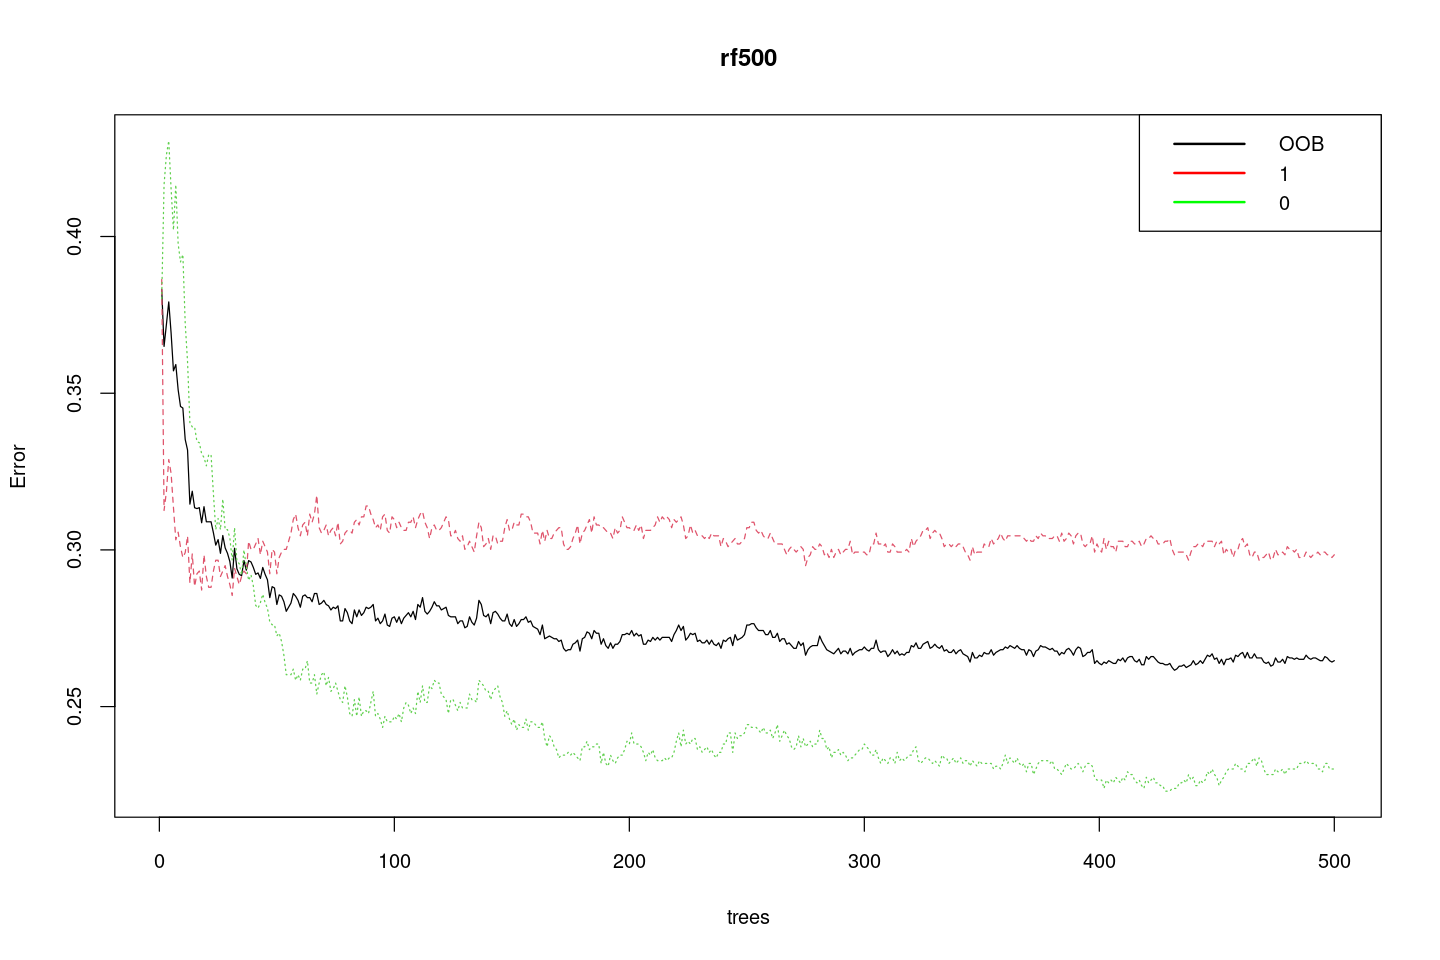

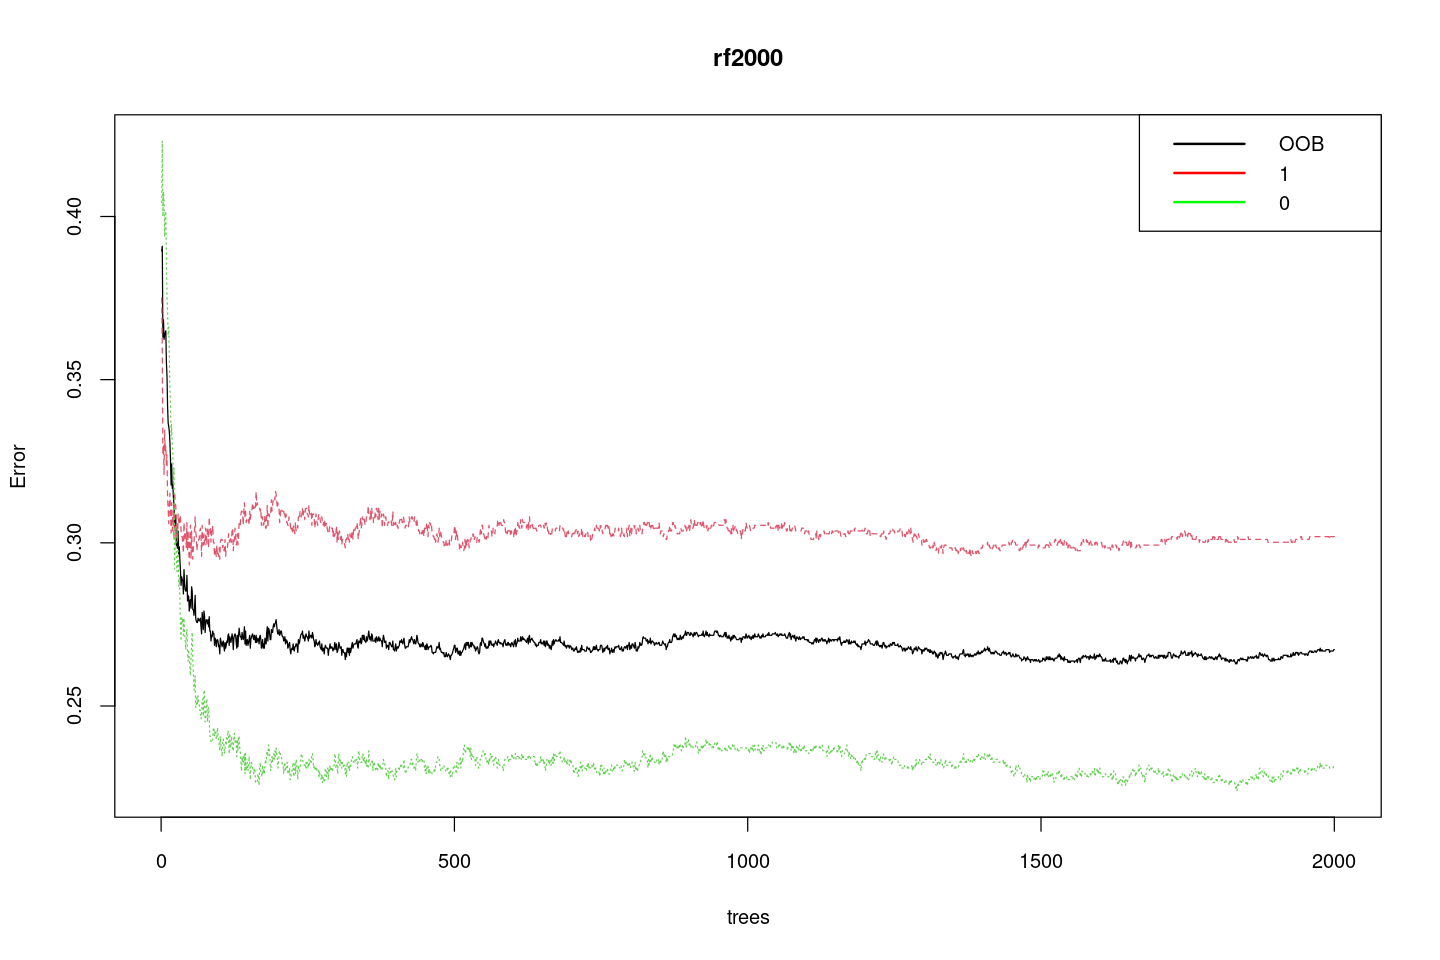

In [9]:
# plot error vs. ntrees graphs
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)
plot(rf500)
legend("topright",c("OOB","1","0"),col=c("black","red", "green"),lty=1,lwd=2)
plot(rf2000)
legend("topright",c("OOB","1","0"),col=c("black","red", "green"),lty=1,lwd=2)


## Concluding choosing the ntree value: <br>
Evidently, the **overall and balanced accuracies for both runs are very similar with a slight increase in sensitivity when ntree = 2000**. The error rates also flatten out after ntree = 500 as seen son the second graph.<br>
However, the time taken for 2000 trees is about 4 times that of 500 trees. When this is scaled to the full dataset, for predicting all the diseases, it will result in a significant amount of time and resources consumed for a relatively smaller increase in sensitivity. <br>
**Thus, ntree = 500 is used for all further trainings in this project**
***

# Tuning Mtry values for Random Forest

***
'mtry' is the number of predictor variables chosen at random for each decision tree. <br> The values tested for this hyperparameter were chosen at intervals to make the experiment more time efficient. <br>
ntree is set as the ideal value from the previous section - 500
***

In [10]:
#ntree was selected earlier
ntree<- 500
#list of mtry values to be tested for each disease
mtry <- list(1,2,4,6,8,10,12)

In [11]:
#creating a list to contain the balanced accuracy for each mtry value
accuracy = numeric(7)
#run random forest with each mtry and then output the balanced accuracy on the test data
#this is done for each disease
for (i in 1:7){
    rf <- randomForest(ASTHMA3~., data = undersampleASTH, ntree = ntree , mtry = mtry[[i]], importance = TRUE)
    cm <-confusionMatrix(predict(rf, test), test$ASTHMA3, positive = '1')
    accuracy[i] <- cm$byClass['Balanced Accuracy']
    rm('rf', 'cm')
}

In [12]:
accuracy2 = numeric(7)
for (i in 1:7){
    rf <- randomForest(CHCSCNCR~., data = undersampleSKIN, ntree = ntree , mtry = mtry[[i]], importance = TRUE)
    cm <-confusionMatrix(predict(rf, test), test$CHCSCNCR, positive = '1')
    accuracy2[i] <- cm$byClass['Balanced Accuracy']
    rm('rf', 'cm')
}

In [13]:
accuracy3 = numeric(7)
for (i in 1:7){
    rf <- randomForest(CHCKDNY2~., data = undersampleKIDNEY, ntree = ntree , mtry = mtry[[i]], importance = TRUE)
    cm <-confusionMatrix(predict(rf, test), test$CHCKDNY2, positive = '1')
    accuracy3[i] <- cm$byClass['Balanced Accuracy']
    rm('rf', 'cm')
}

In [14]:
accuracy4 = numeric(7)
for (i in 1:7){
    rf <- randomForest(HAVARTH4~., data = undersampleARTH, ntree = ntree , mtry = mtry[[i]], importance = TRUE)
    cm <-confusionMatrix(predict(rf, test), test$HAVARTH4, positive = '1')
    accuracy4[i] <- cm$byClass['Balanced Accuracy']
    rm('rf', 'cm')
}

In [15]:
accuracy5 = numeric(7)
for (i in 1:7){
    rf <- randomForest(CHCOCNCR~., data = undersampleCANCER, ntree = ntree , mtry = mtry[[i]], importance = TRUE)
    cm <-confusionMatrix(predict(rf, test), test$CHCOCNCR, positive = '1')
    accuracy5[i] <- cm$byClass['Balanced Accuracy']
    rm('rf', 'cm')
}

In [16]:
accuracy6 = numeric(7)
for (i in 1:7){
    rf <- randomForest(CHCCOPD2~., data = undersampleLUNG, ntree = ntree , mtry = mtry[[i]], importance = TRUE)
    cm <-confusionMatrix(predict(rf, test), test$CHCCOPD2, positive = '1')
    accuracy6[i] <- cm$byClass['Balanced Accuracy']
    rm('rf', 'cm')
}

In [17]:
accuracy7 = numeric(7)
for (i in 1:7){
    rf <- randomForest(DIABETE4~., data = undersampleDIAB, ntree = ntree , mtry = mtry[[i]], importance = TRUE)
    cm <-confusionMatrix(predict(rf, test), test$DIABETE4, positive = '1')
    accuracy7[i] <- cm$byClass['Balanced Accuracy']
    rm('rf', 'cm')
}

In [18]:
accuracy8 = numeric(7)
for (i in 1:7){
    rf <- randomForest(CVDCRHD4~., data = undersampleHEART, ntree = ntree , mtry = mtry[[i]], importance = TRUE)
    cm <-confusionMatrix(predict(rf, test), test$CVDCRHD4, positive = '1')
    accuracy8[i] <- cm$byClass['Balanced Accuracy']
    rm('rf', 'cm')
}

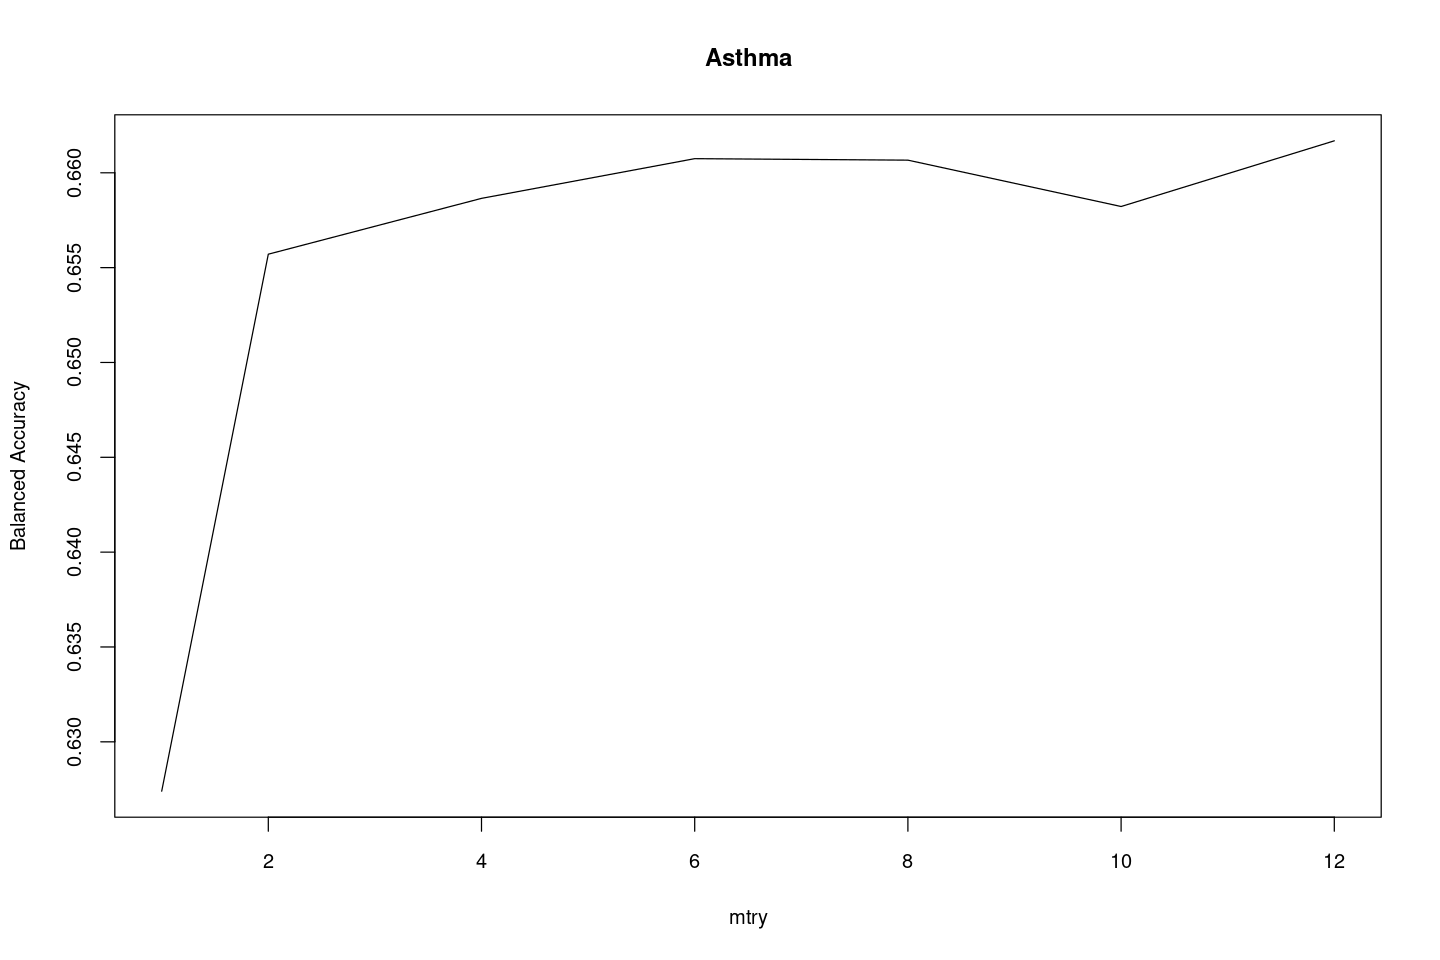

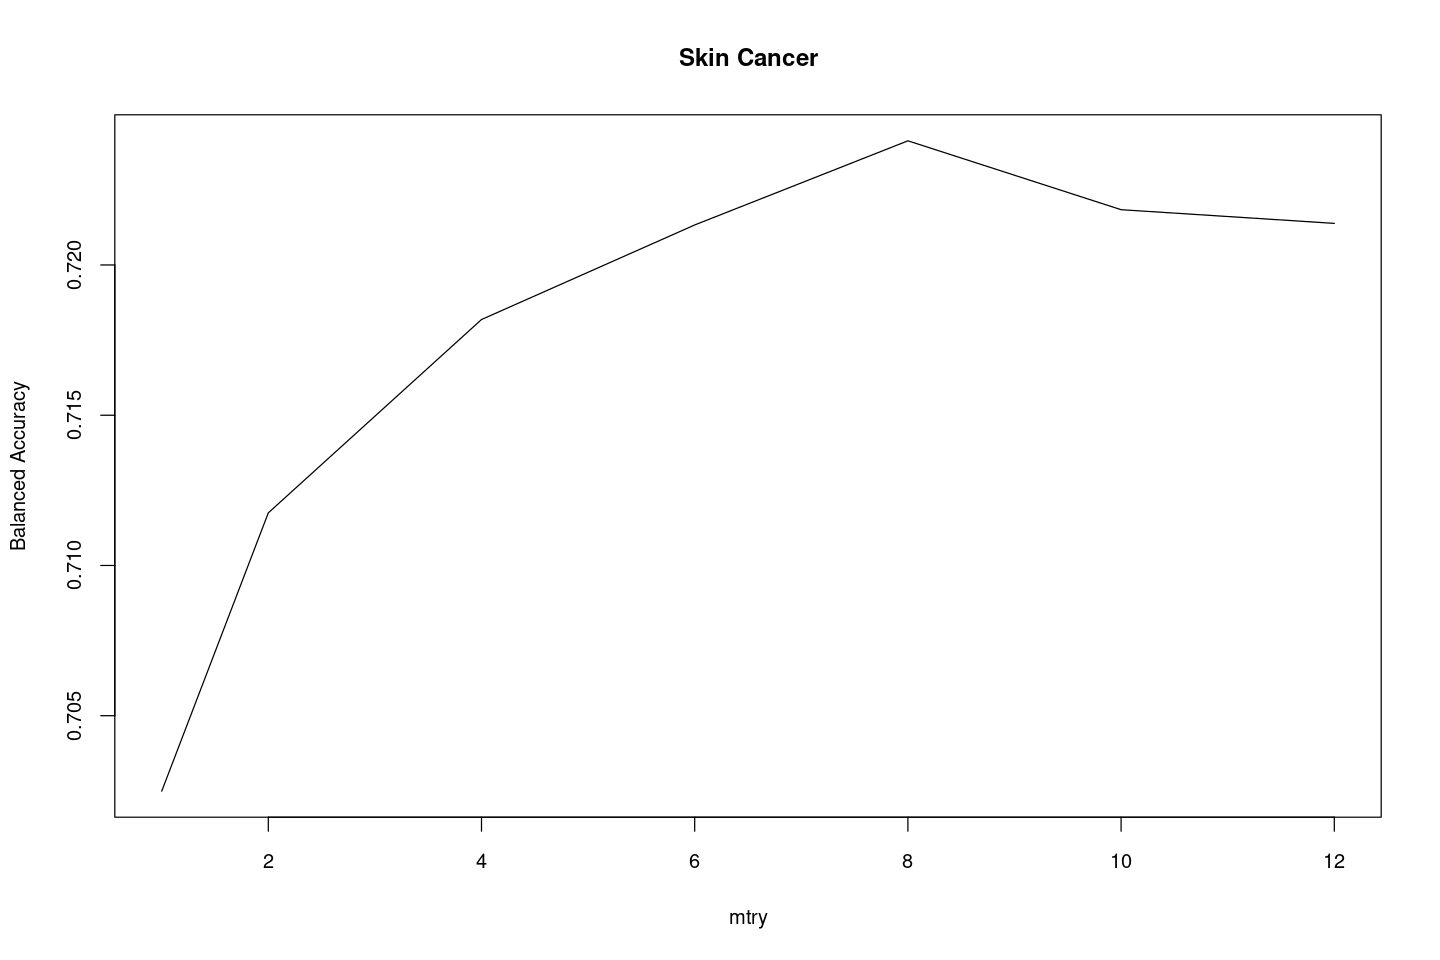

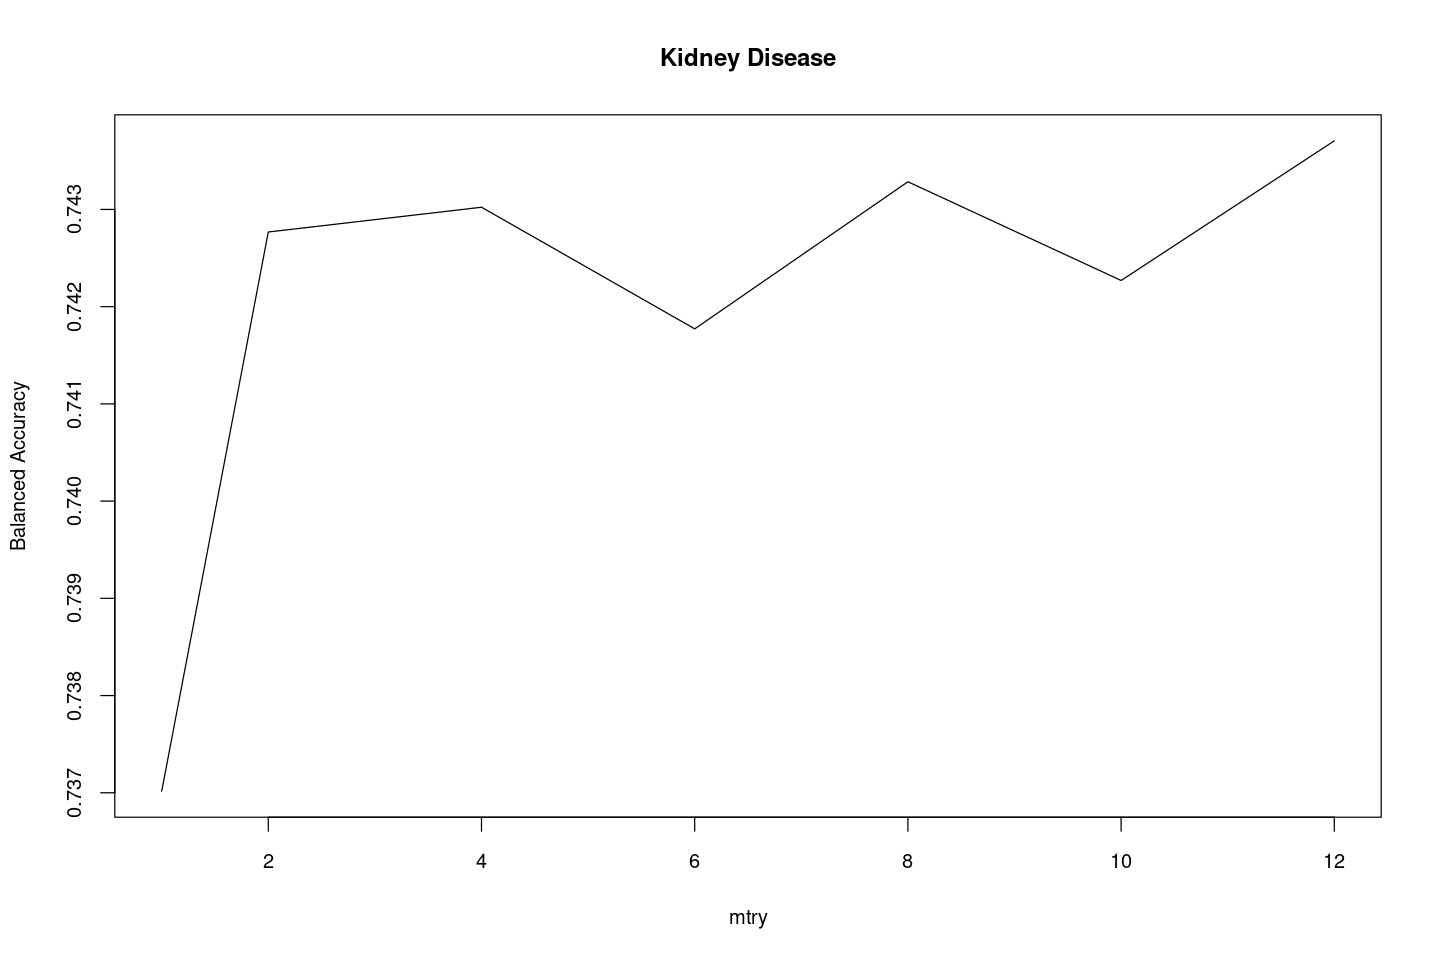

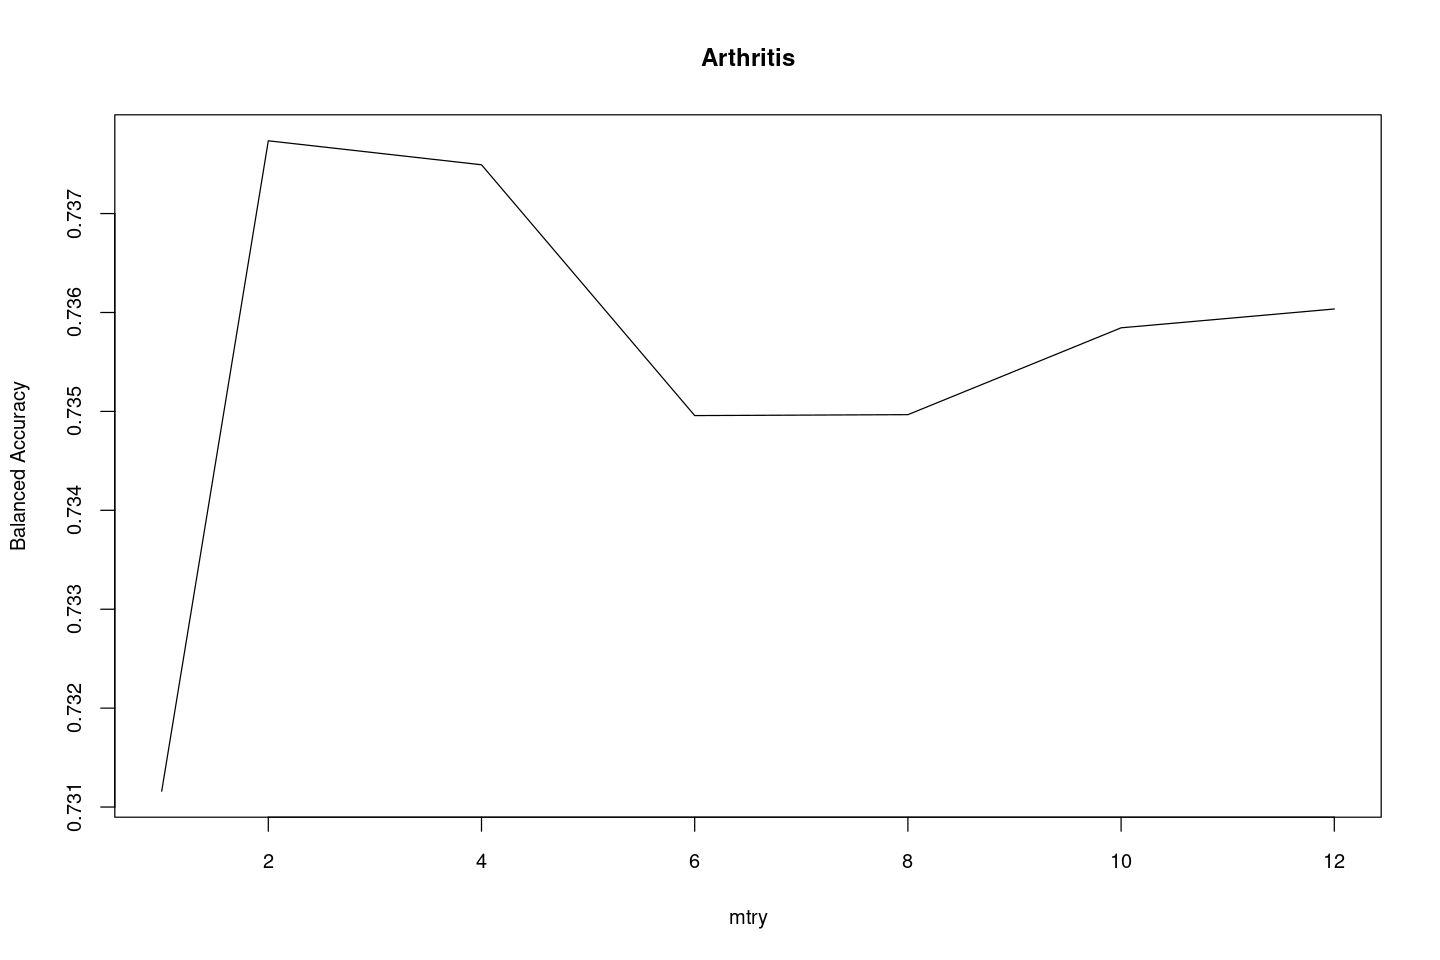

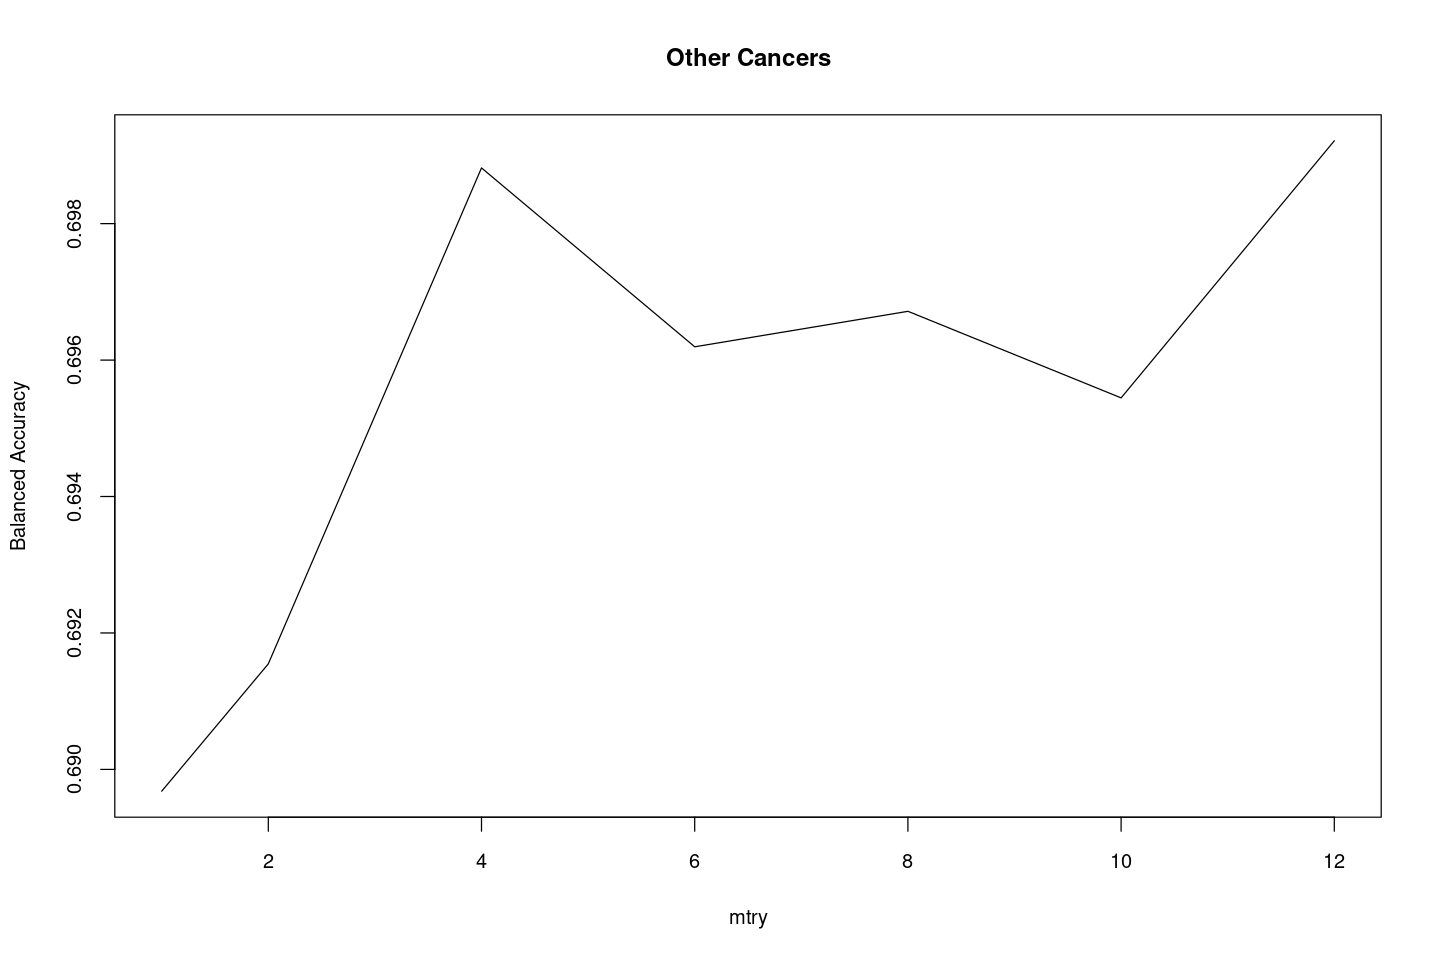

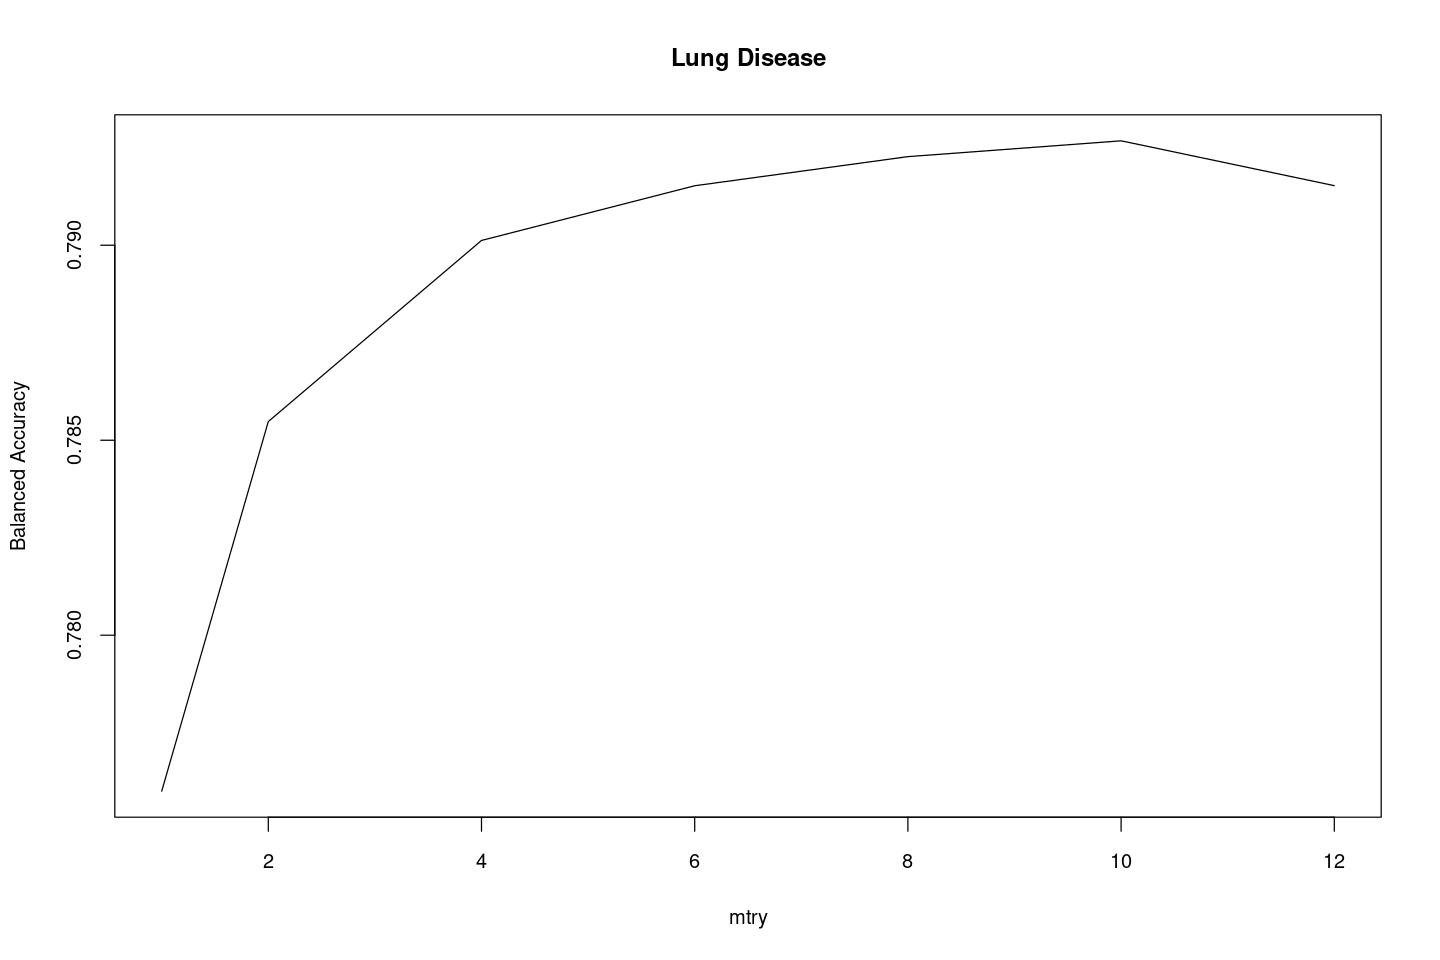

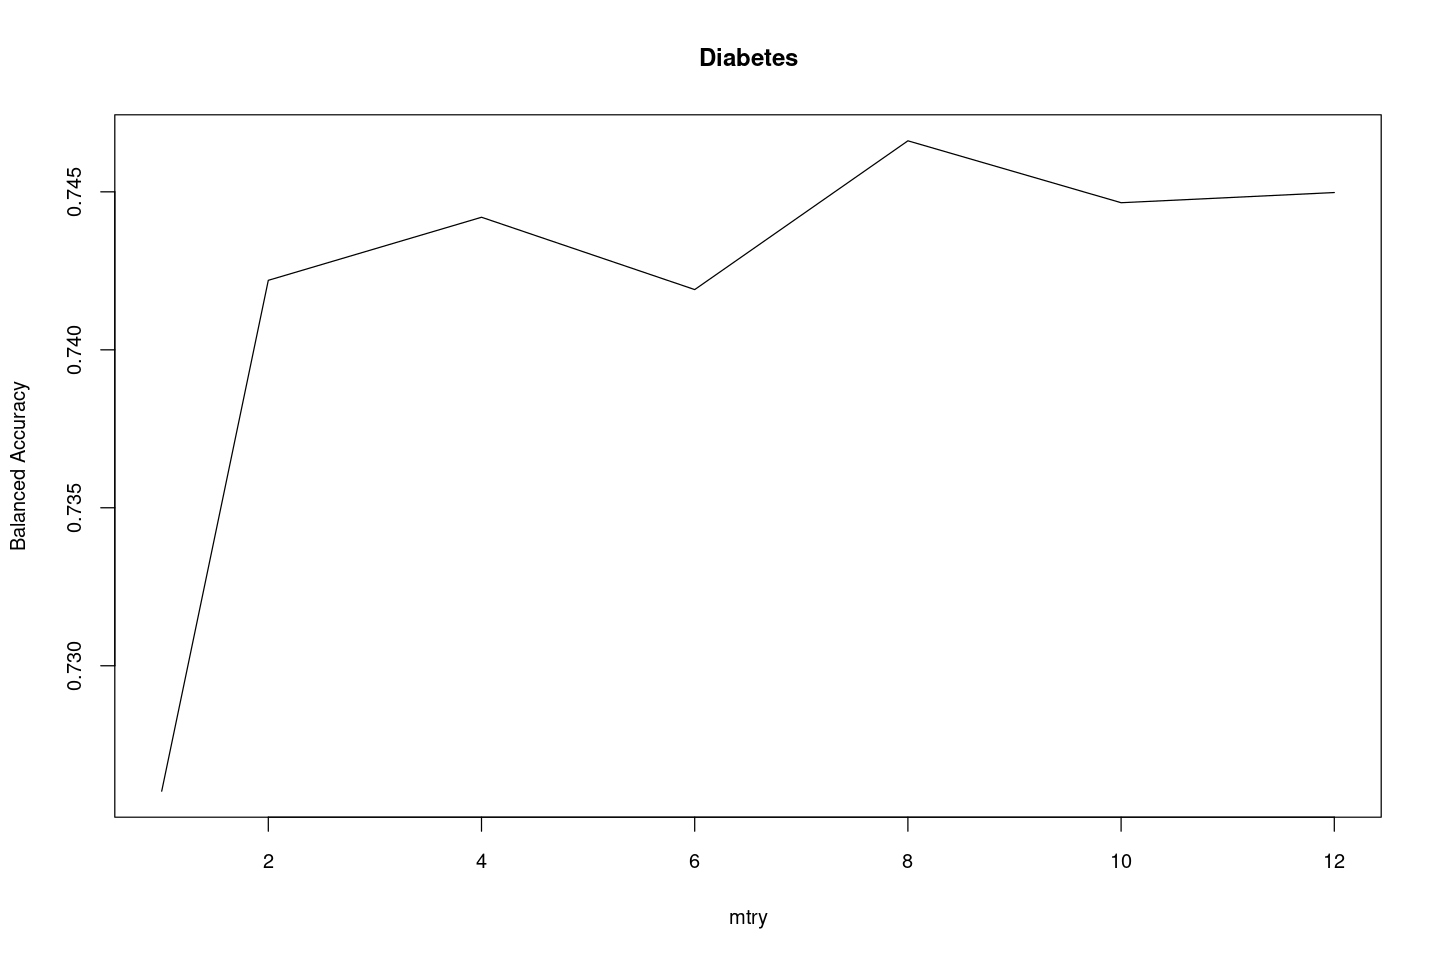

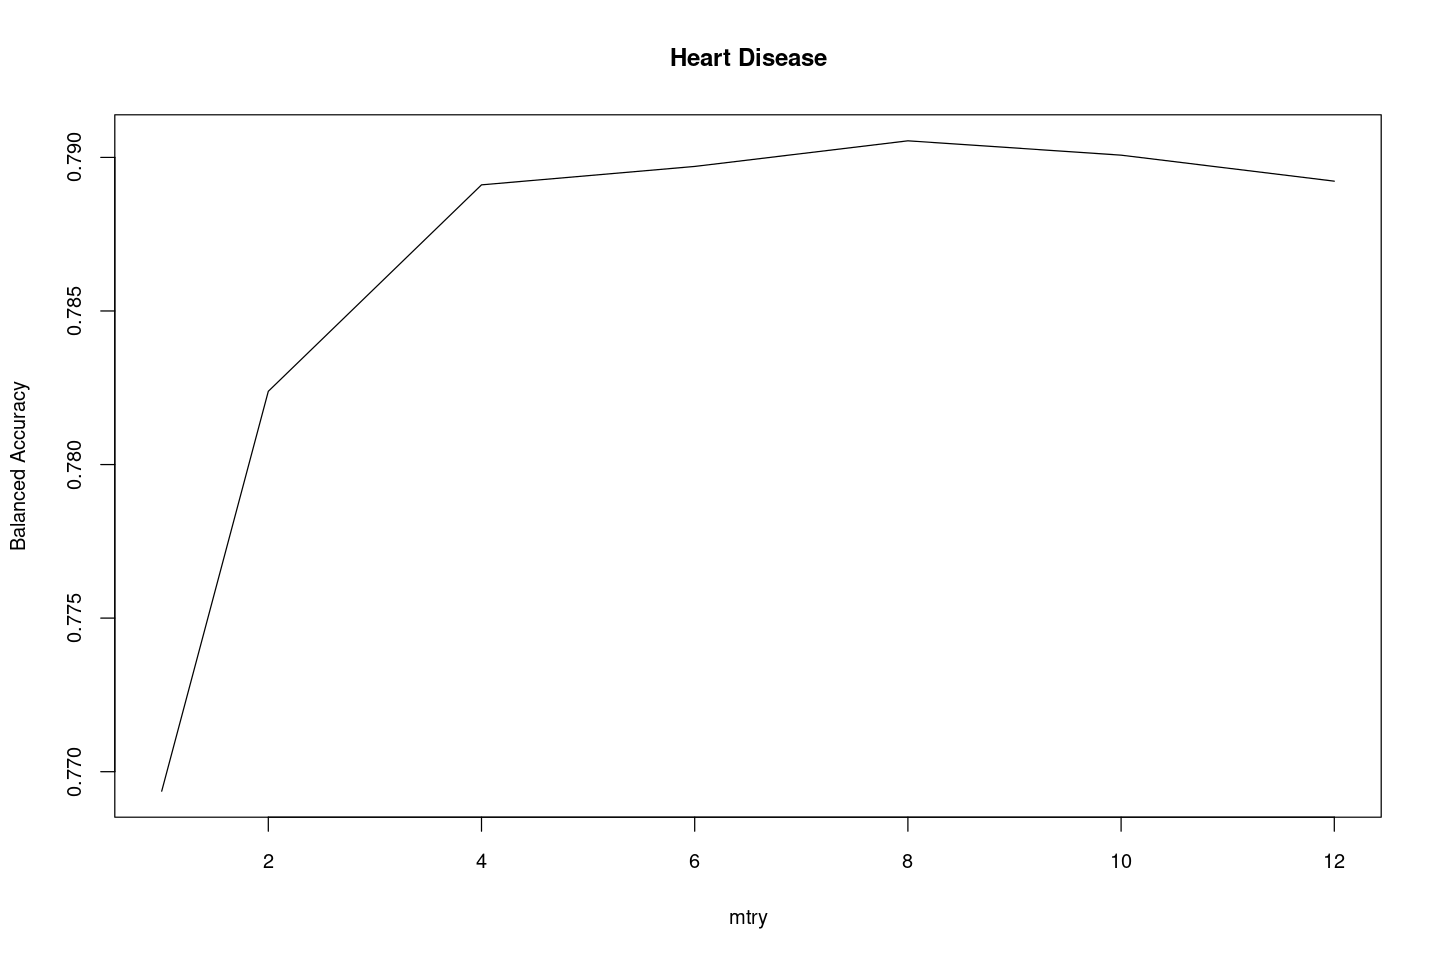

In [19]:
# Plot the mtry vs. balanced accuracy graphs for each disease

plot(mtry, accuracy, type = 'l', ylab = 'Balanced Accuracy', main = 'Asthma')

plot(mtry, accuracy2, type = 'l', ylab = 'Balanced Accuracy', main = 'Skin Cancer')

plot(mtry, accuracy3, type = 'l', ylab = 'Balanced Accuracy', main = 'Kidney Disease')

plot(mtry, accuracy4, type = 'l', ylab = 'Balanced Accuracy', main = 'Arthritis')

plot(mtry, accuracy5, type = 'l', ylab = 'Balanced Accuracy', main = 'Other Cancers')

plot(mtry, accuracy6, type = 'l', ylab = 'Balanced Accuracy', main = 'Lung Disease')

plot(mtry, accuracy7, type = 'l', ylab = 'Balanced Accuracy', main = 'Diabetes')

plot(mtry, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Heart Disease')

In [20]:
end_time <- Sys.time() #store system time as end_time for logging the duration of previous task
print(end_time - start_time)

Time difference of 32.95571 mins


# Training the RF on the full dataset

In [21]:
#Now using the full dataset to train the models with the best mtry values and ntree selected
#Train and test data split
set.seed(100) #set the same seed for reproducability
ind <- sample(nrow(newDataset), 0.7*nrow(newDataset), replace = FALSE)
train <- newDataset[ind,]
test <- newDataset[-ind,]

In [22]:
# use undersampling to fix class imbalance issues
# a unique balanced dataset is stored for training each target variable
undersampleASTH <- ovun.sample(ASTHMA3~., data = train, method = "under", p = 0.5)$data
undersampleHEART <- ovun.sample(CVDCRHD4~., data = train, method = "under", p = 0.5)$data
undersampleSKIN <- ovun.sample(CHCSCNCR~., data = train, method = "under", p = 0.5)$data
undersampleKIDNEY <- ovun.sample(CHCKDNY2~., data = train, method = "under", p = 0.5)$data
undersampleARTH <- ovun.sample(HAVARTH4~., data = train, method = "under", p = 0.5)$data
undersampleCANCER <- ovun.sample(CHCOCNCR~., data = train, method = "under", p = 0.5)$data
undersampleLUNG <- ovun.sample(CHCCOPD2~., data = train, method = "under", p = 0.5)$data
undersampleDIAB <- ovun.sample(DIABETE4~., data = train, method = "under", p = 0.5)$data

In [39]:
#used undersampled data to train randomForest for each target disease with ntree = 500

start_time <- Sys.time() #log time
#Asthma random forest model with mtry = 6
rf_Asthma <- randomForest(ASTHMA3~., data = undersampleASTH, ntree = 500, mtry = 6, importance = TRUE)

#Skin cancer random forest model with mtry = 12
rf_Skin <- randomForest(CHCSCNCR~., data = undersampleSKIN, ntree = 500, mtry = 12, importance = TRUE)

#Kidney disease random forest model with mtry = 4
rf_Kidney <- randomForest(CHCKDNY2~., data = undersampleKIDNEY, ntree = 500, mtry = 4, importance = TRUE)

#Arthiritis disease random forest model with mtry = 2
rf_Arthritis <- randomForest(HAVARTH4~., data = undersampleARTH, ntree = 500, mtry = 2, importance = TRUE)

#Cancer random forest model with mtry = 10 
rf_Cancer <- randomForest(CHCOCNCR~., data = undersampleCANCER, ntree = 500 , mtry = 10, importance = TRUE)
#cm_Cancer <- confusionMatrix(predict(rf_Cancer, test), test$CHCOCNCR, positive = '1') #check testing output

#Lung Disease random forest model with mtry = 8
rf_Lung <- randomForest(CHCCOPD2~., data = undersampleLUNG, ntree = 500 , mtry = 8, importance = TRUE)
#cm_Lung <-confusionMatrix(predict(rf_Lung, test), test$CHCCOPD2, positive = '1') #check testing output

#Diabetes random forest model with mtry = 10
rf_Diabetes <- randomForest(DIABETE4~., data = undersampleDIAB, ntree = 500 , mtry = 10, importance = TRUE)
#cm_Diabetes <-confusionMatrix(predict(rf_Diabetes, test), test$DIABETE4, positive = '1') #check testing output

#Heart Disease random forest model with mtry = 4
rf_Heart <- randomForest(CVDCRHD4~., data = undersampleHEART, ntree = 500 , mtry = 4, importance = TRUE)
#cm_Heart <-confusionMatrix(predict(rf_Heart, testHeart), test$CVDCRHD4, positive = '1') #check testing output
end_time <- Sys.time() #log time
print(end_time - start_time)

Time difference of 1.530328 hours


In [ ]:
#save the trained random forest models for future use if desired

# save(rf_Asthma,file = "rf_Asthma.RData")
# save(rf_Skin,file = "rf_Skin.RData")
# save(rf_Kidney,file = "rf_Kidney.RData")
# save(rf_Arthritis,file = "rf_Arthritis.RData")
# save(rf_Cancer,file = "rf_Cancer.RData")
# save(rf_Lung,file = "rf_Lung.RData")
# save(rf_Diabetes,file = "rf_Diabetes.RData")
# save(rf_Heart,file = "rf_Heart.RData")

***
## More hyperparameter tuning
### Adjusting threshold and calculating performance metrics for each model
***

In [26]:
#load the trained randomforest models if required
# load("rf_Asthma.RData")
# load("rf_Skin.RData")
# load("rf_Kidney.RData")
# load("rf_Arthritis.RData")
# load("rf_Cancer.RData")
# load("rf_Lung.RData")
# load("rf_Diabetes.RData")
# load("rf_Heart.RData")

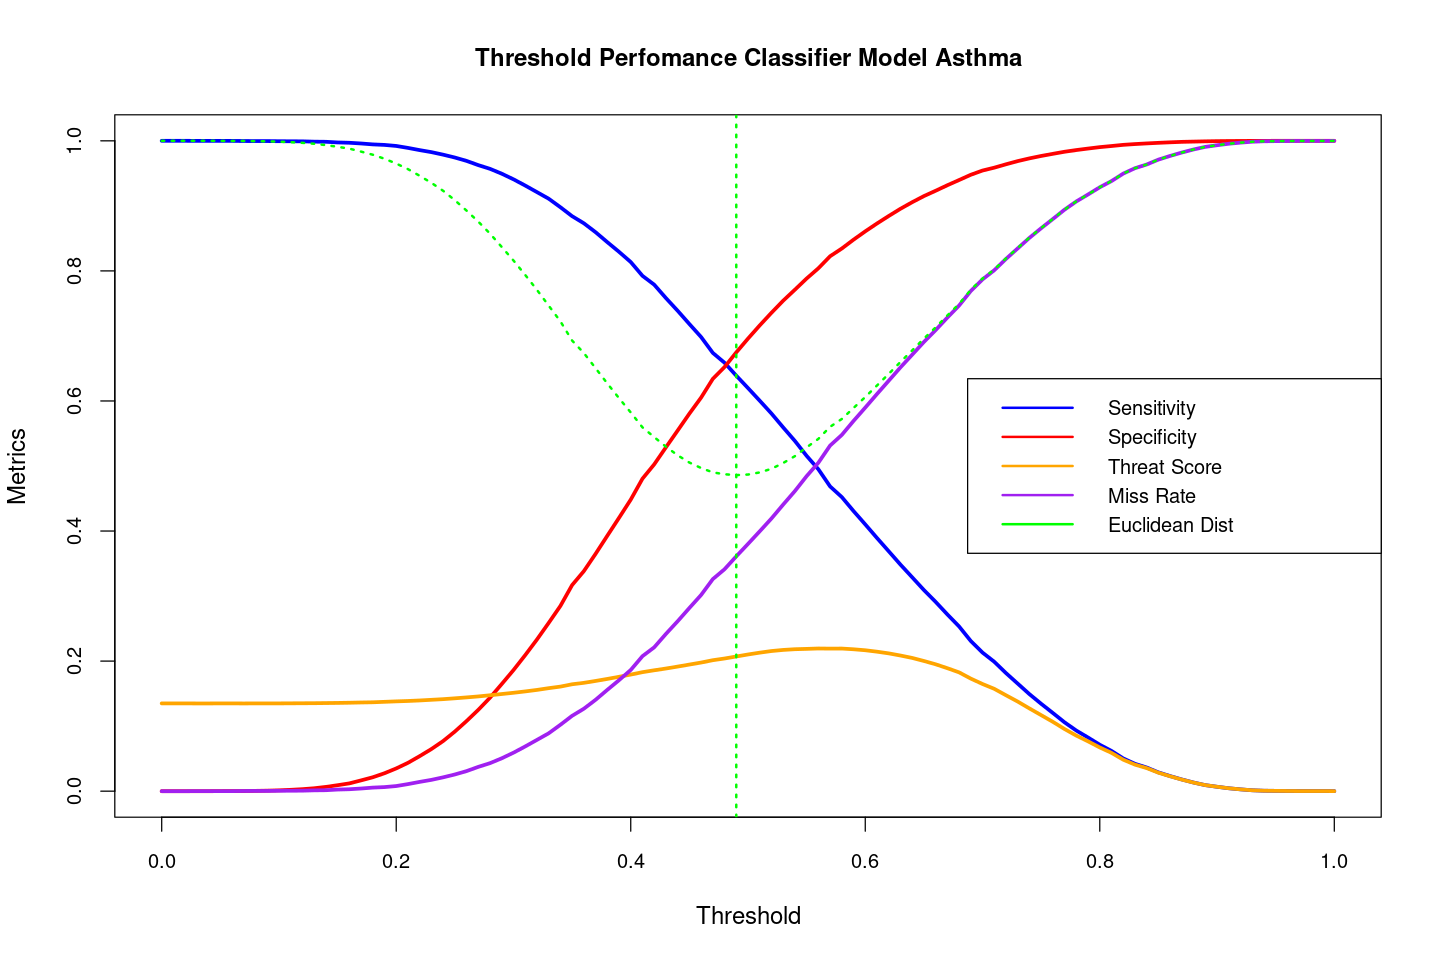

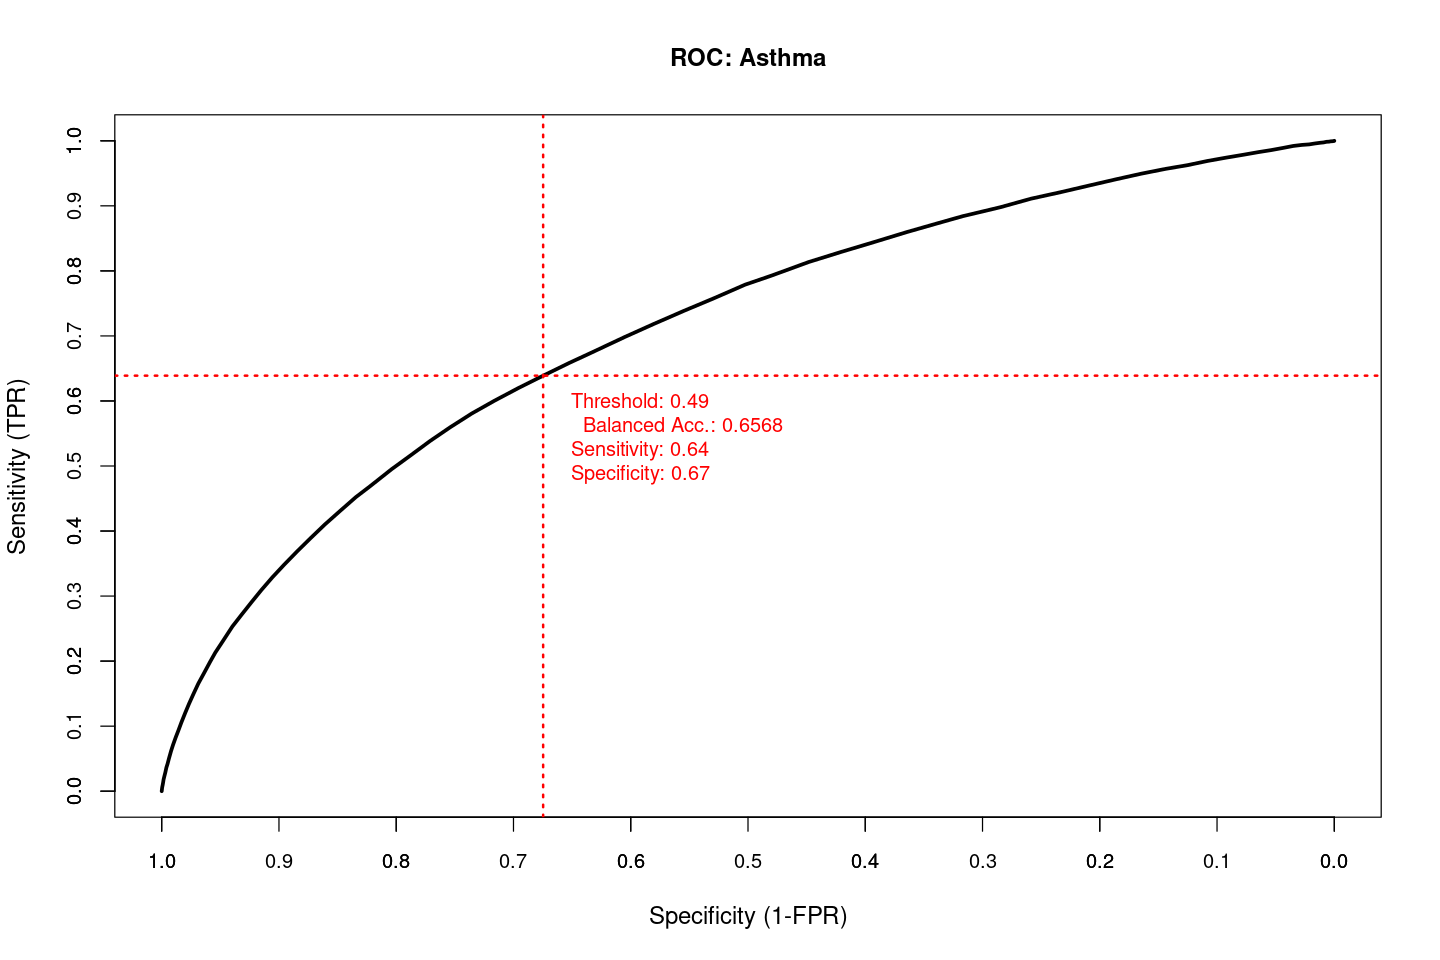

In [27]:
#setting options for this cell for better viewing
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)

#calling function to plot graphs and view values for each disease
measures_Asthma<-getTreeClassifications(myTree = rf_Asthma,
                                   testDataset = test,
                                   title='Asthma',
                                   plot=TRUE, OUTPUT_FIELD = 'ASTHMA3')

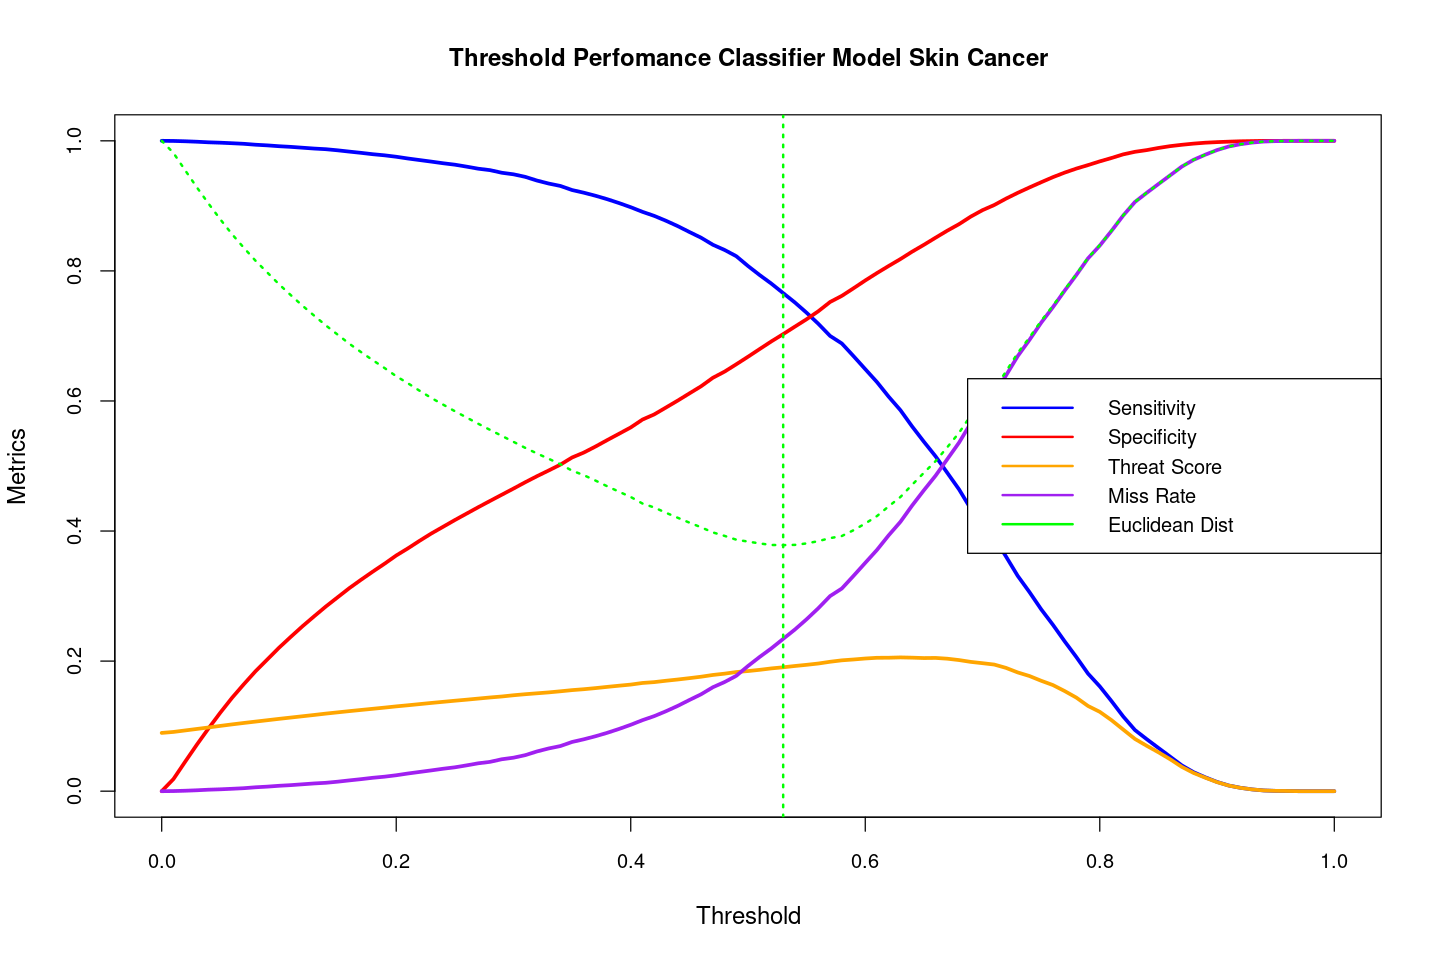

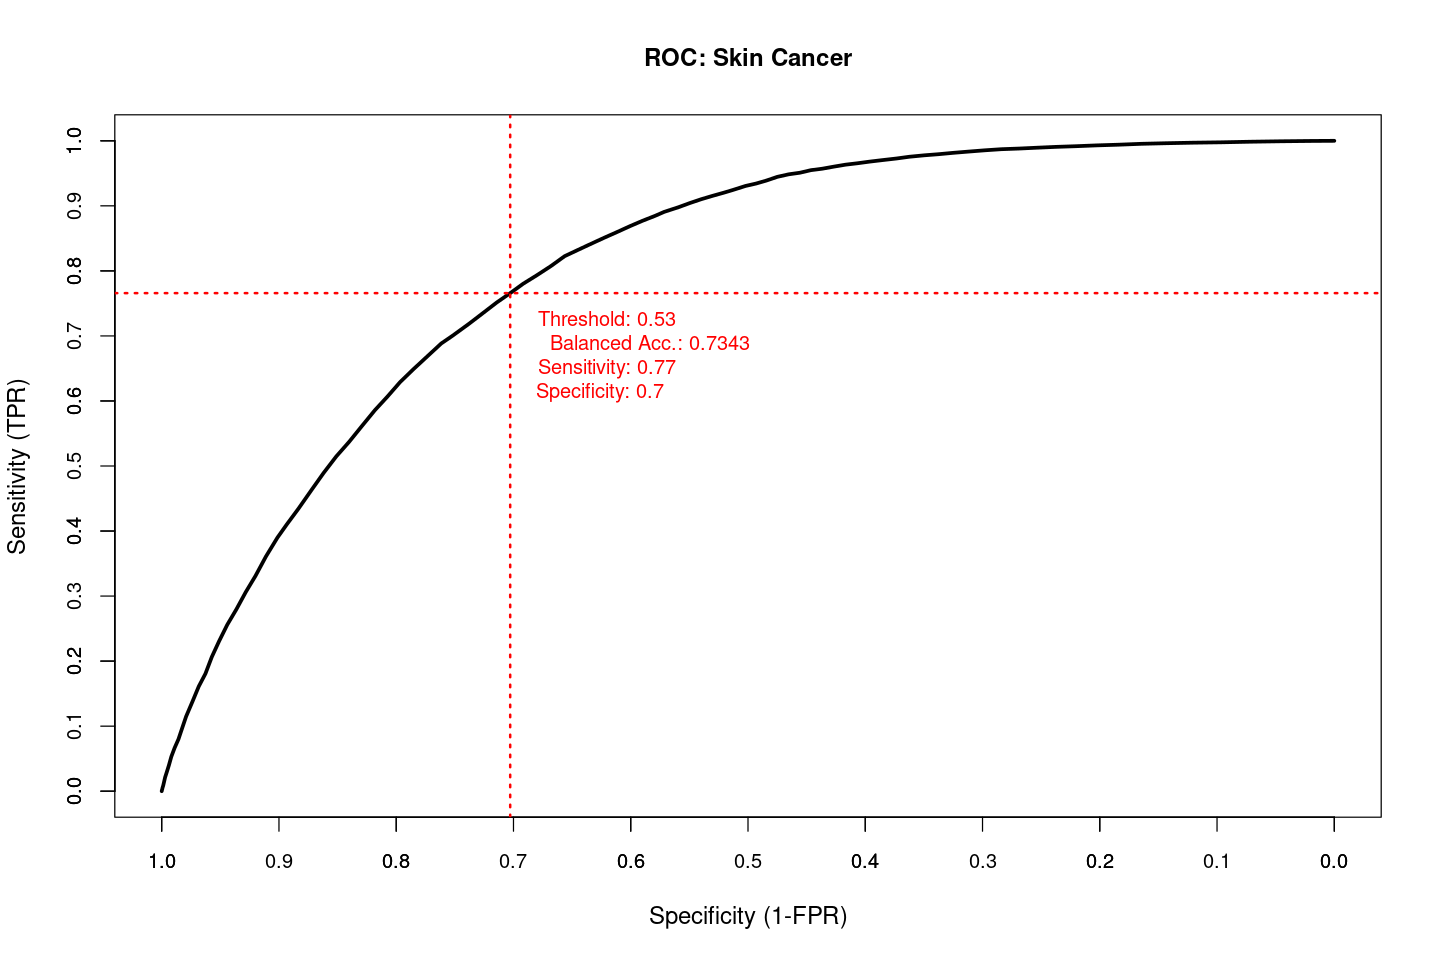

In [28]:
measures_Skin<-getTreeClassifications(myTree = rf_Skin,
                                   testDataset = test,
                                   title='Skin Cancer',
                                   plot=TRUE, OUTPUT_FIELD = 'CHCSCNCR')

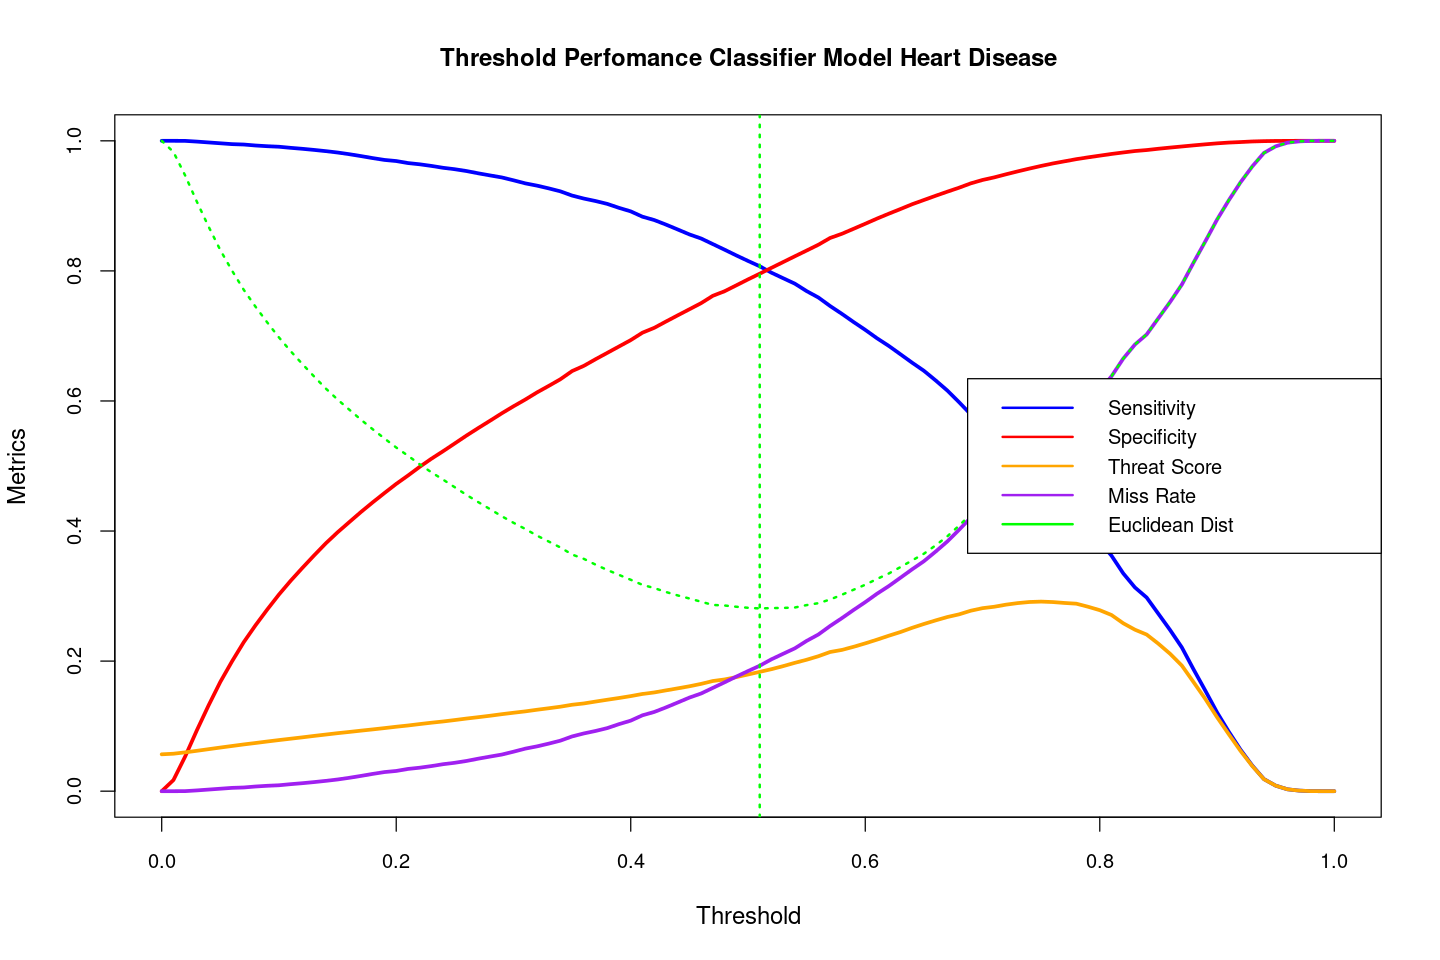

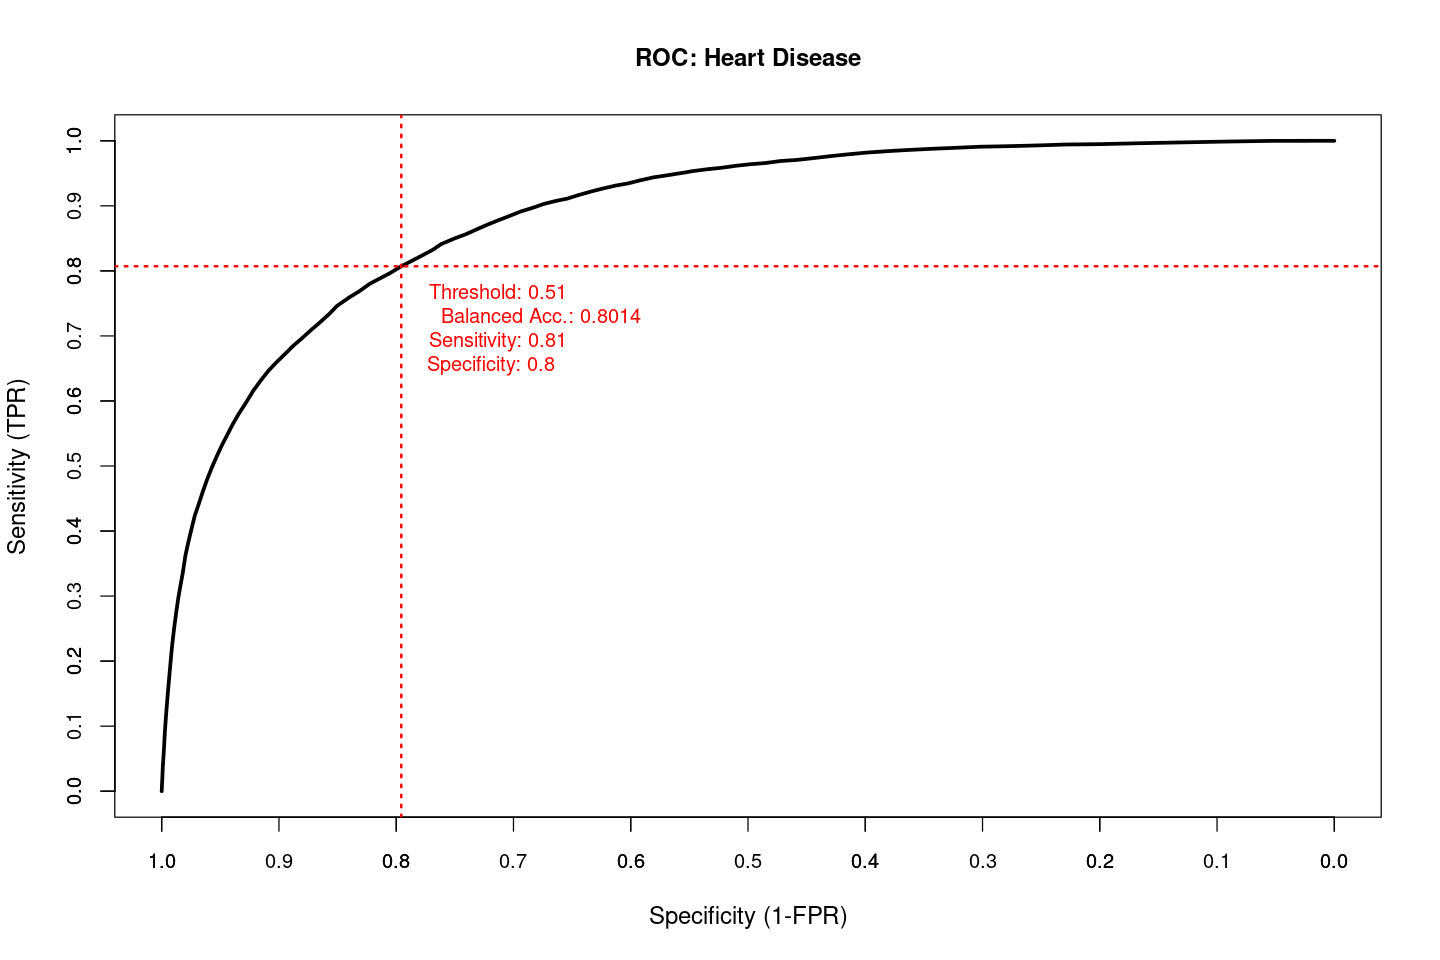

In [29]:
measures_Heart<-getTreeClassifications(myTree = rf_Heart,
                                   testDataset = test,
                                   title='Heart Disease',
                                   plot=TRUE, OUTPUT_FIELD = 'CVDCRHD4')

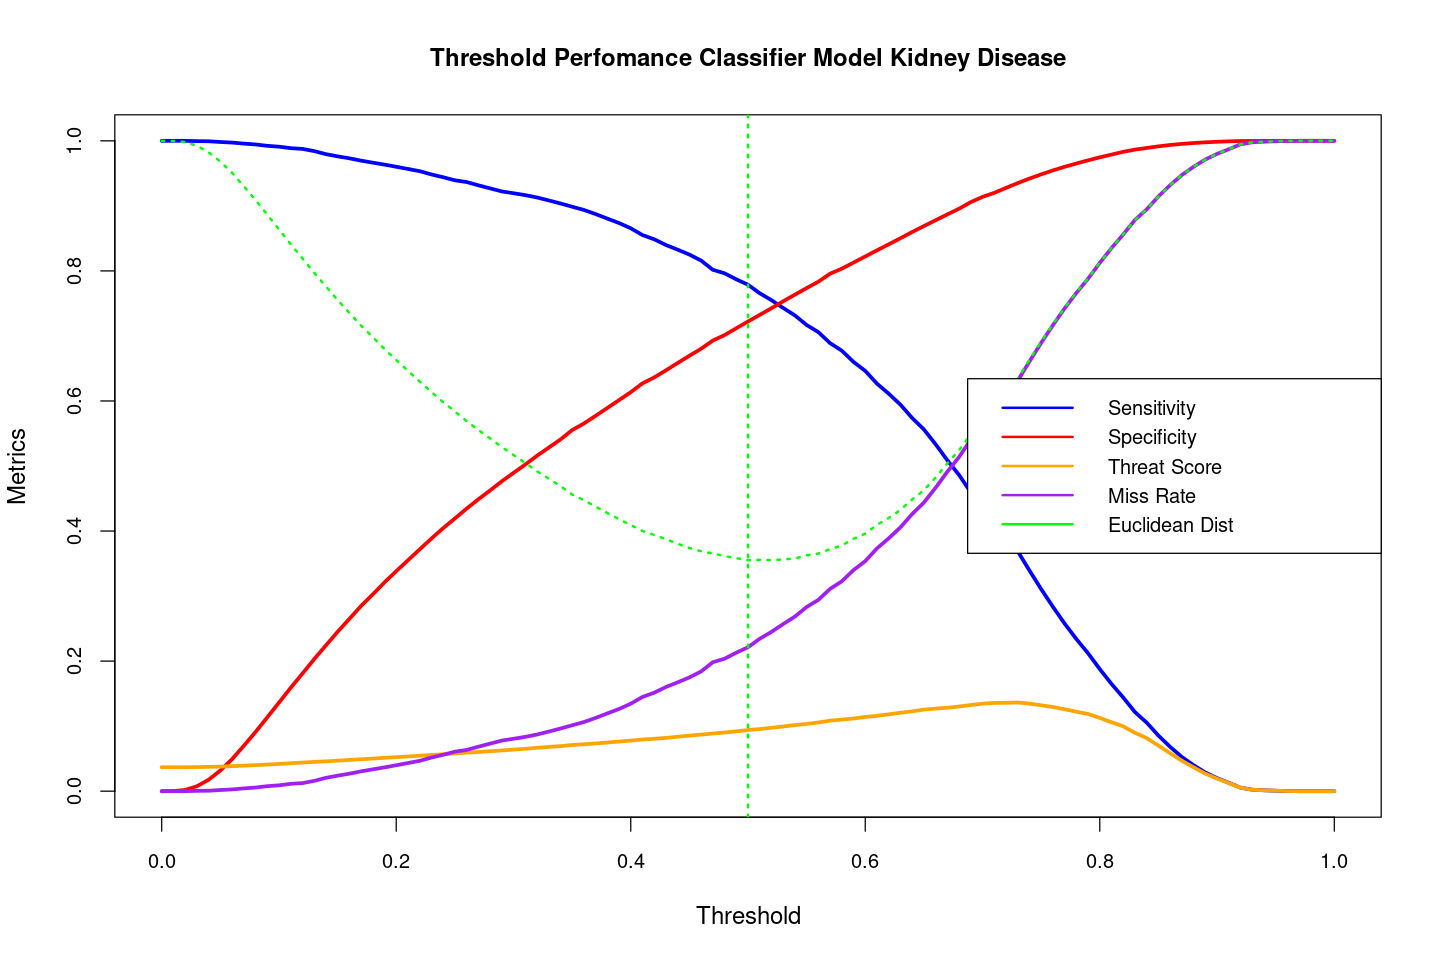

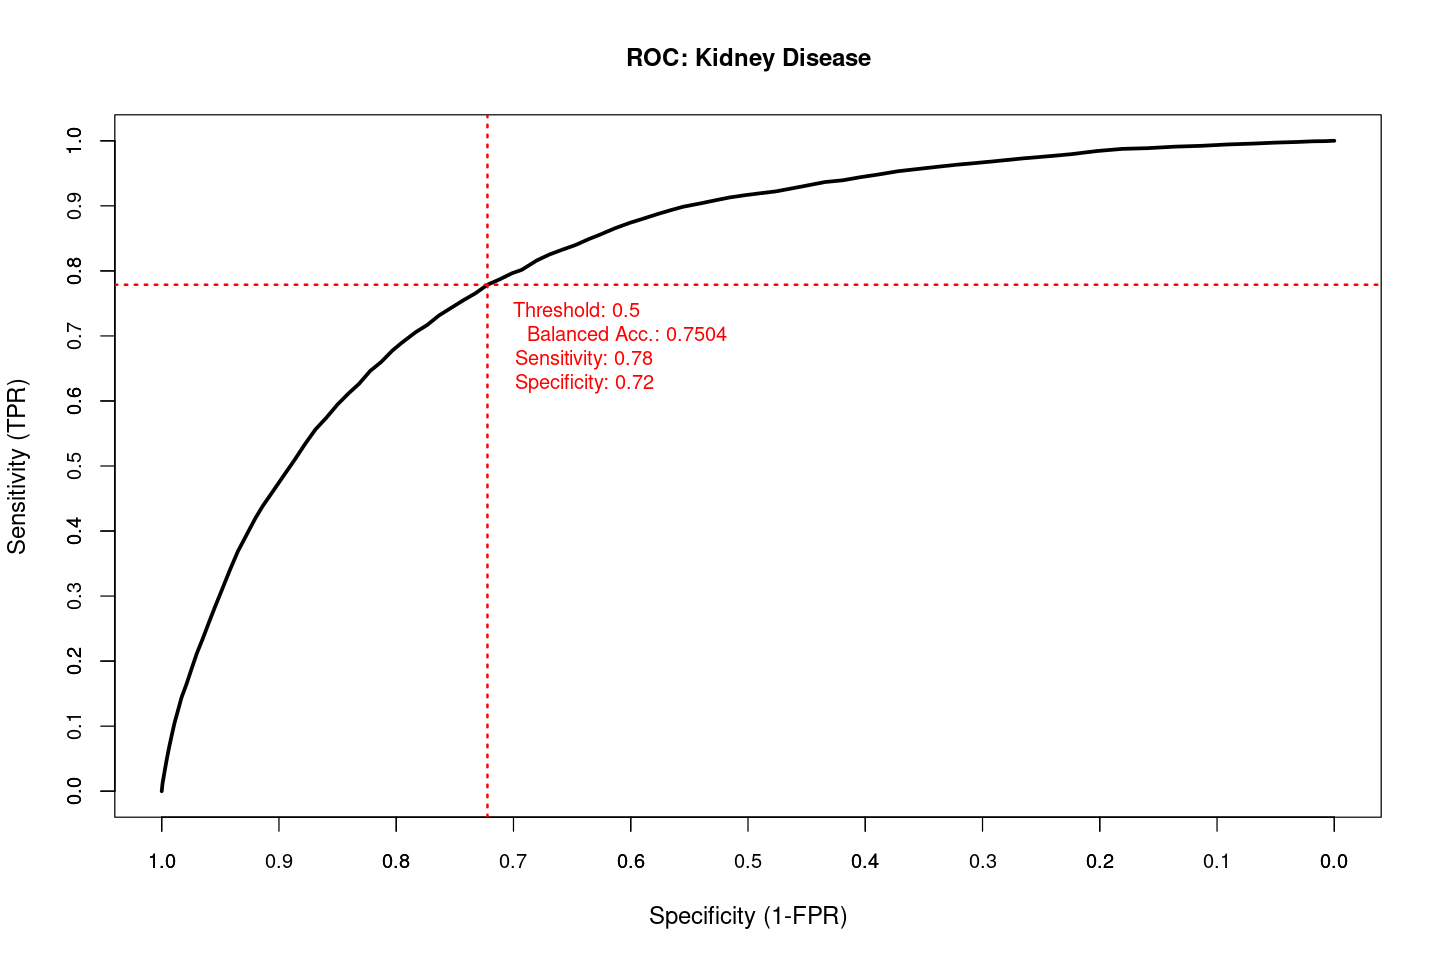

In [30]:
measures_Kidney<-getTreeClassifications(myTree = rf_Kidney,
                                   testDataset = test,
                                   title='Kidney Disease',
                                   plot=TRUE, OUTPUT_FIELD = 'CHCKDNY2')

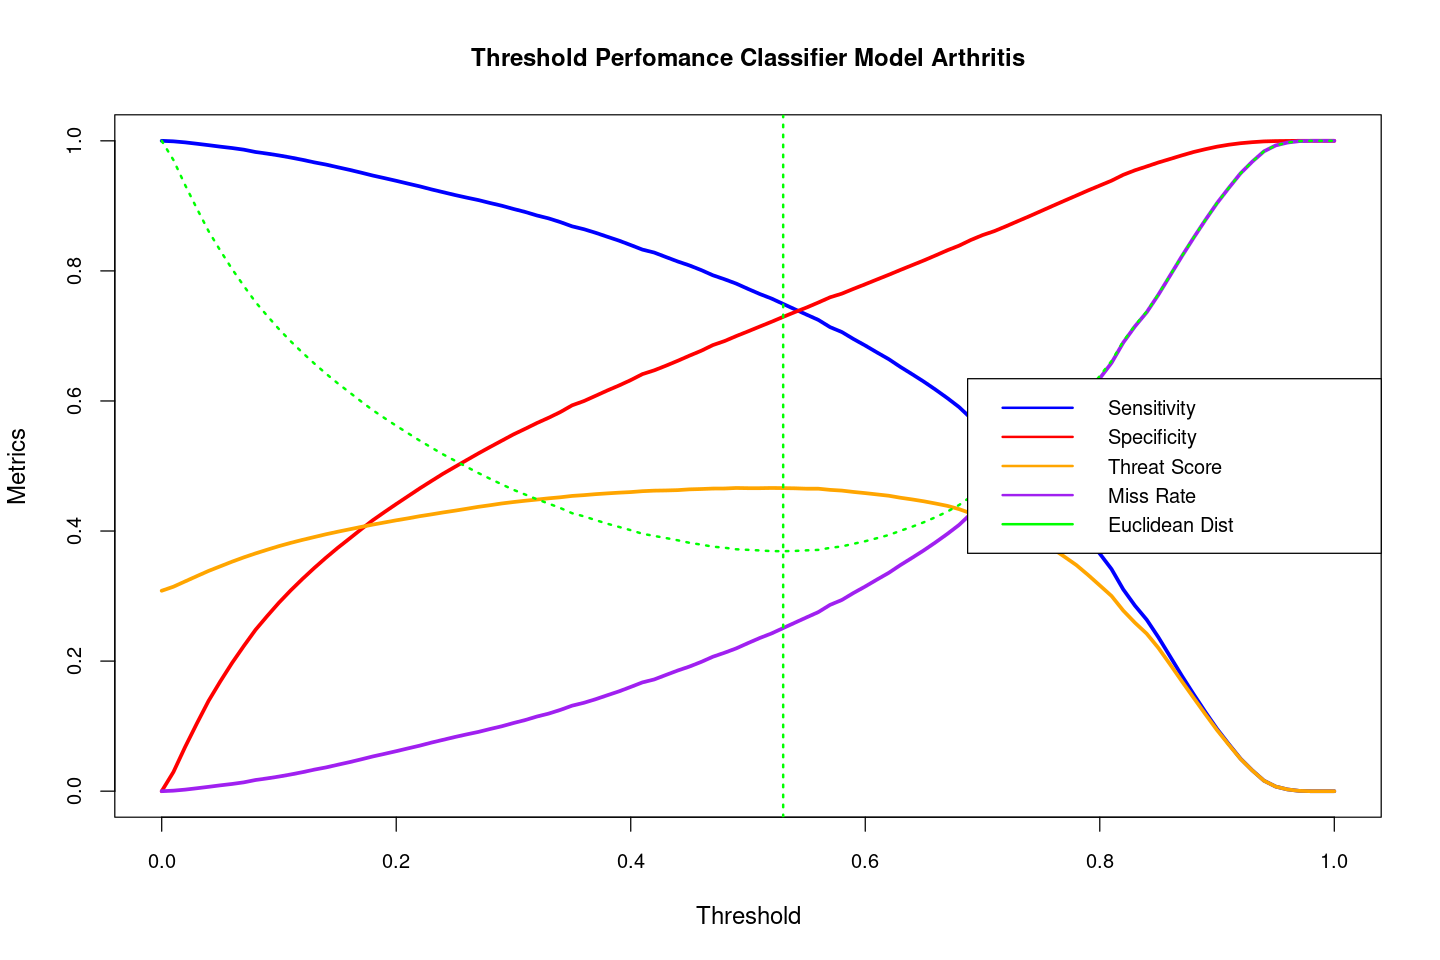

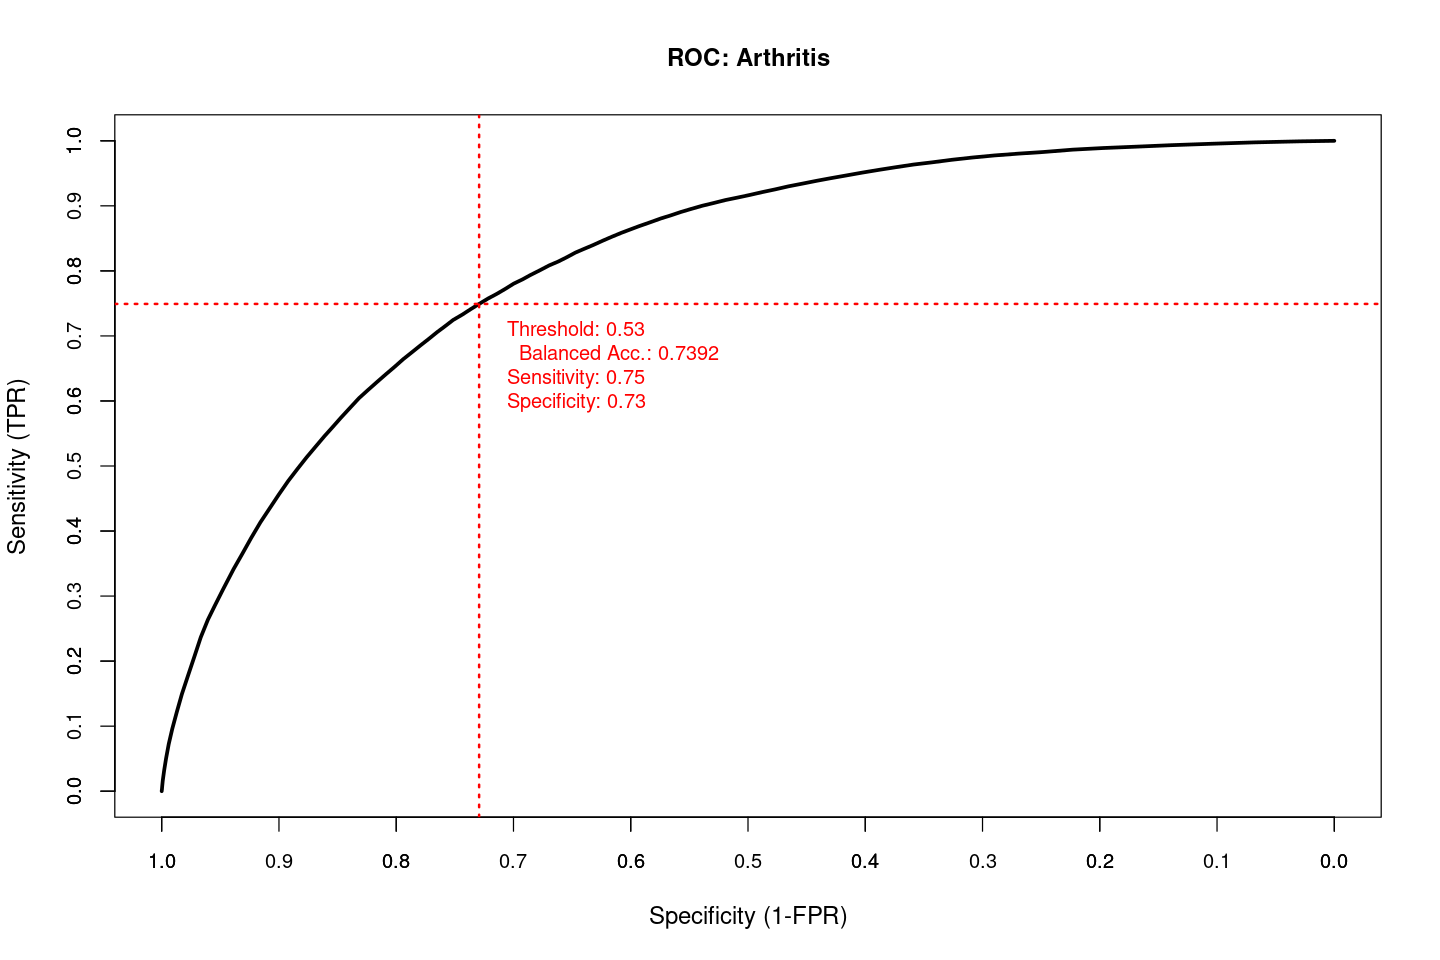

In [31]:
measures_Arthritis<-getTreeClassifications(myTree = rf_Arthritis,
                                   testDataset = test,
                                   title='Arthritis',
                                   plot=TRUE, OUTPUT_FIELD = 'HAVARTH4')

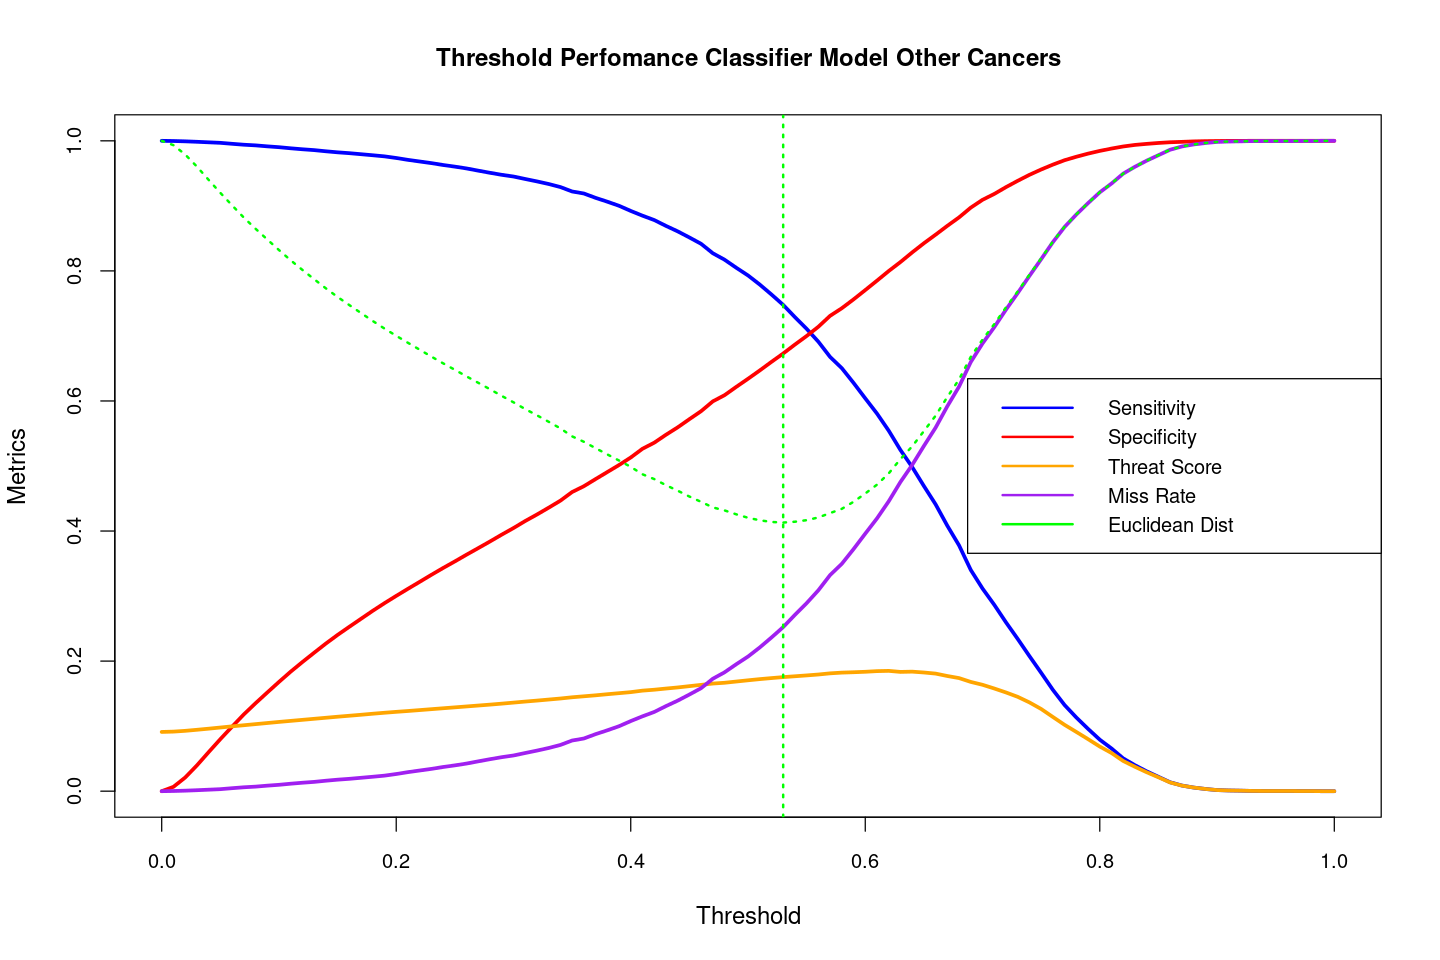

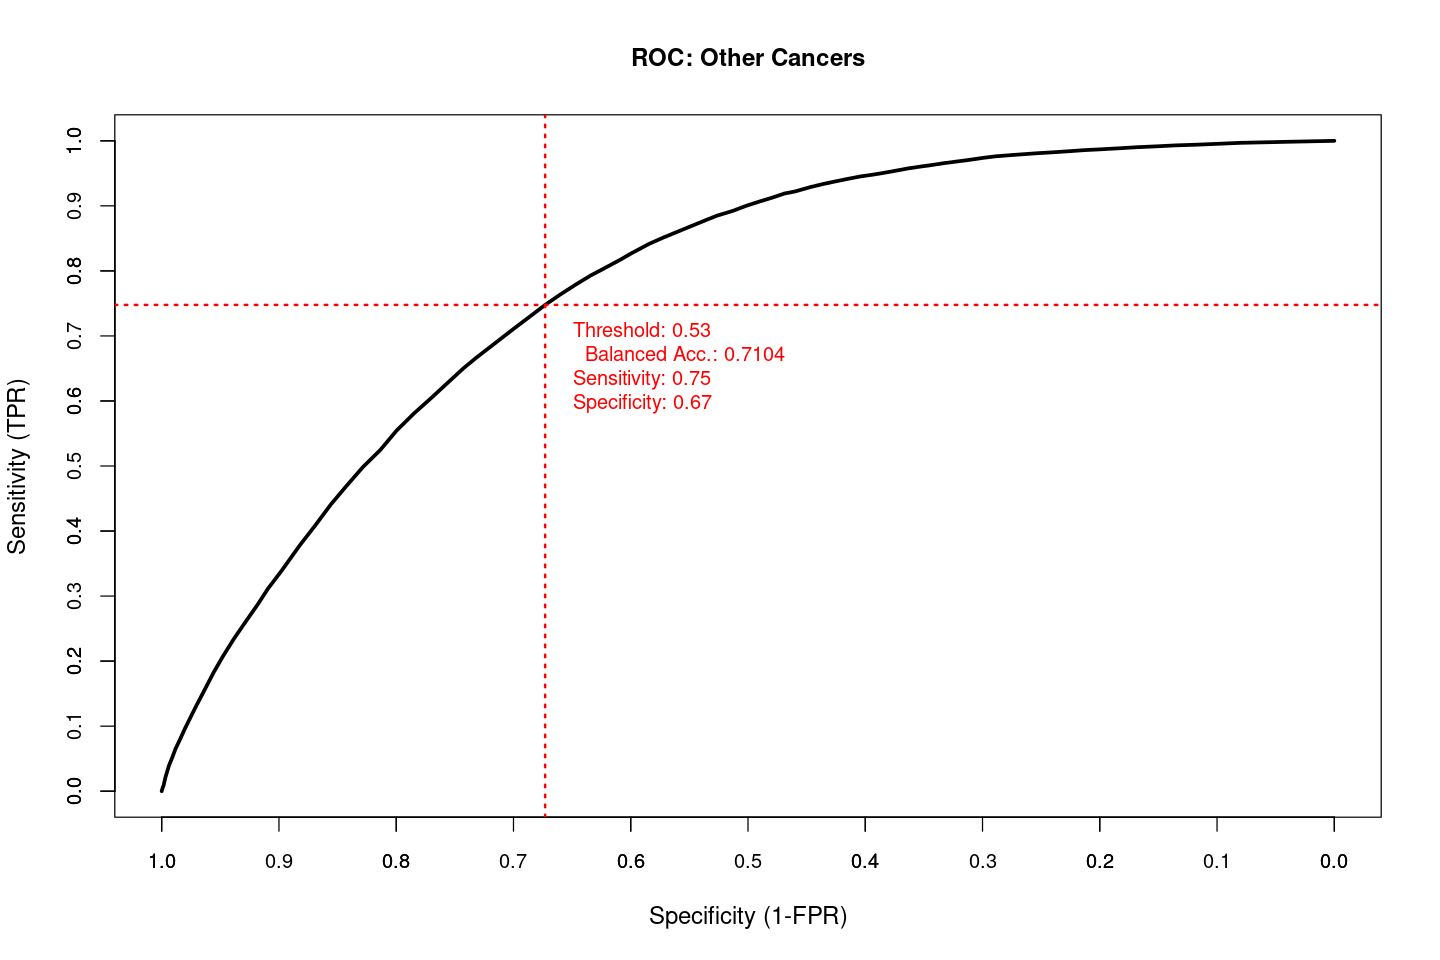

In [32]:
measures_Cancer<-getTreeClassifications(myTree = rf_Cancer,
                                   testDataset = test,
                                   title='Other Cancers',
                                   plot=TRUE, OUTPUT_FIELD = 'CHCOCNCR')

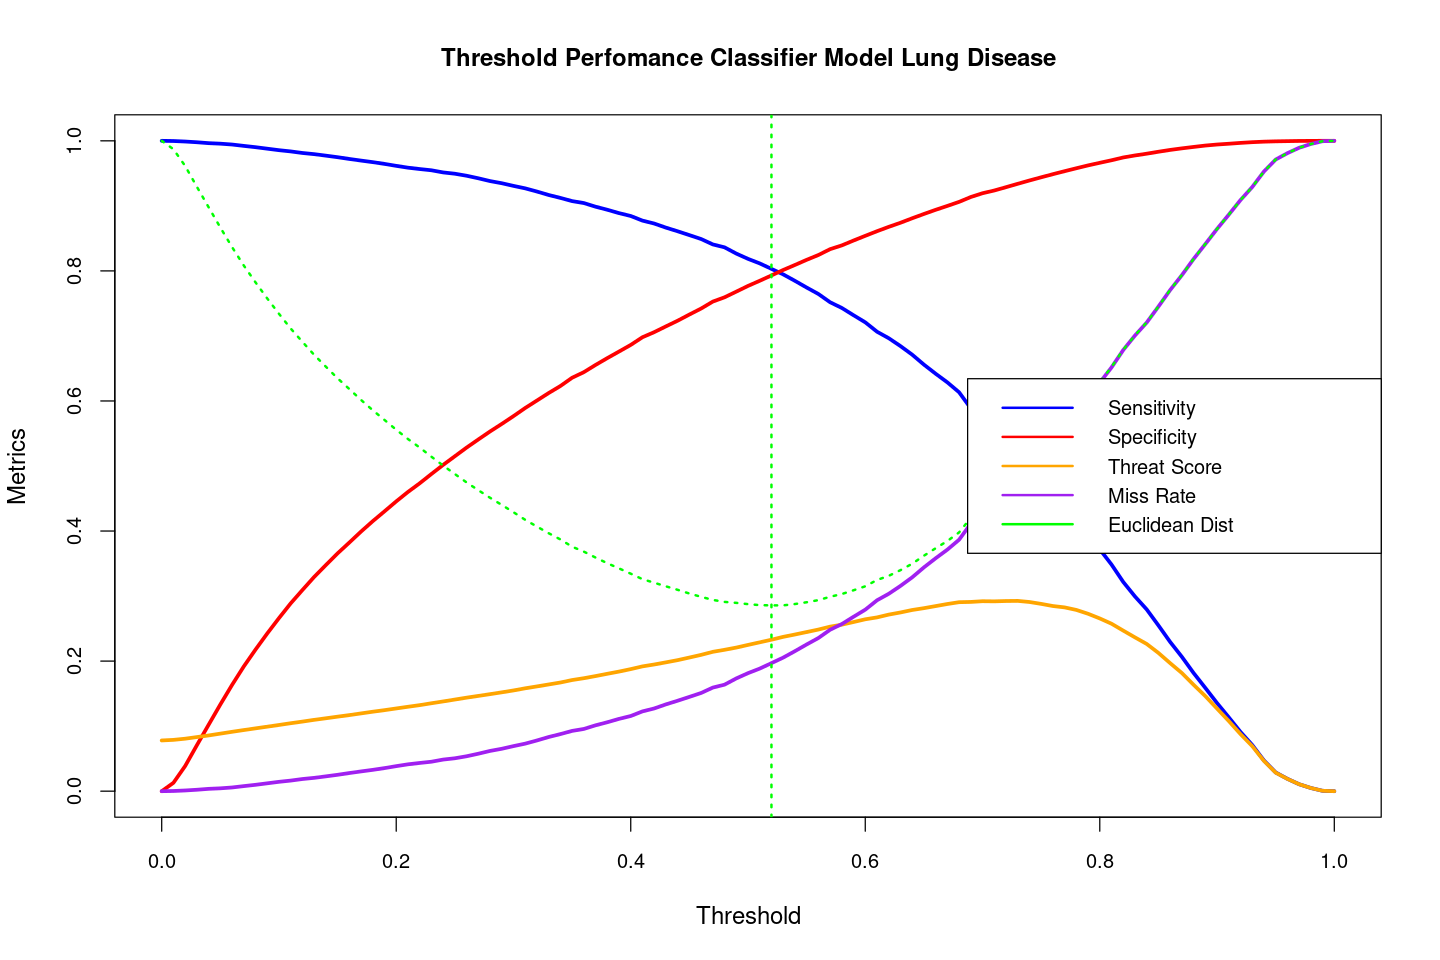

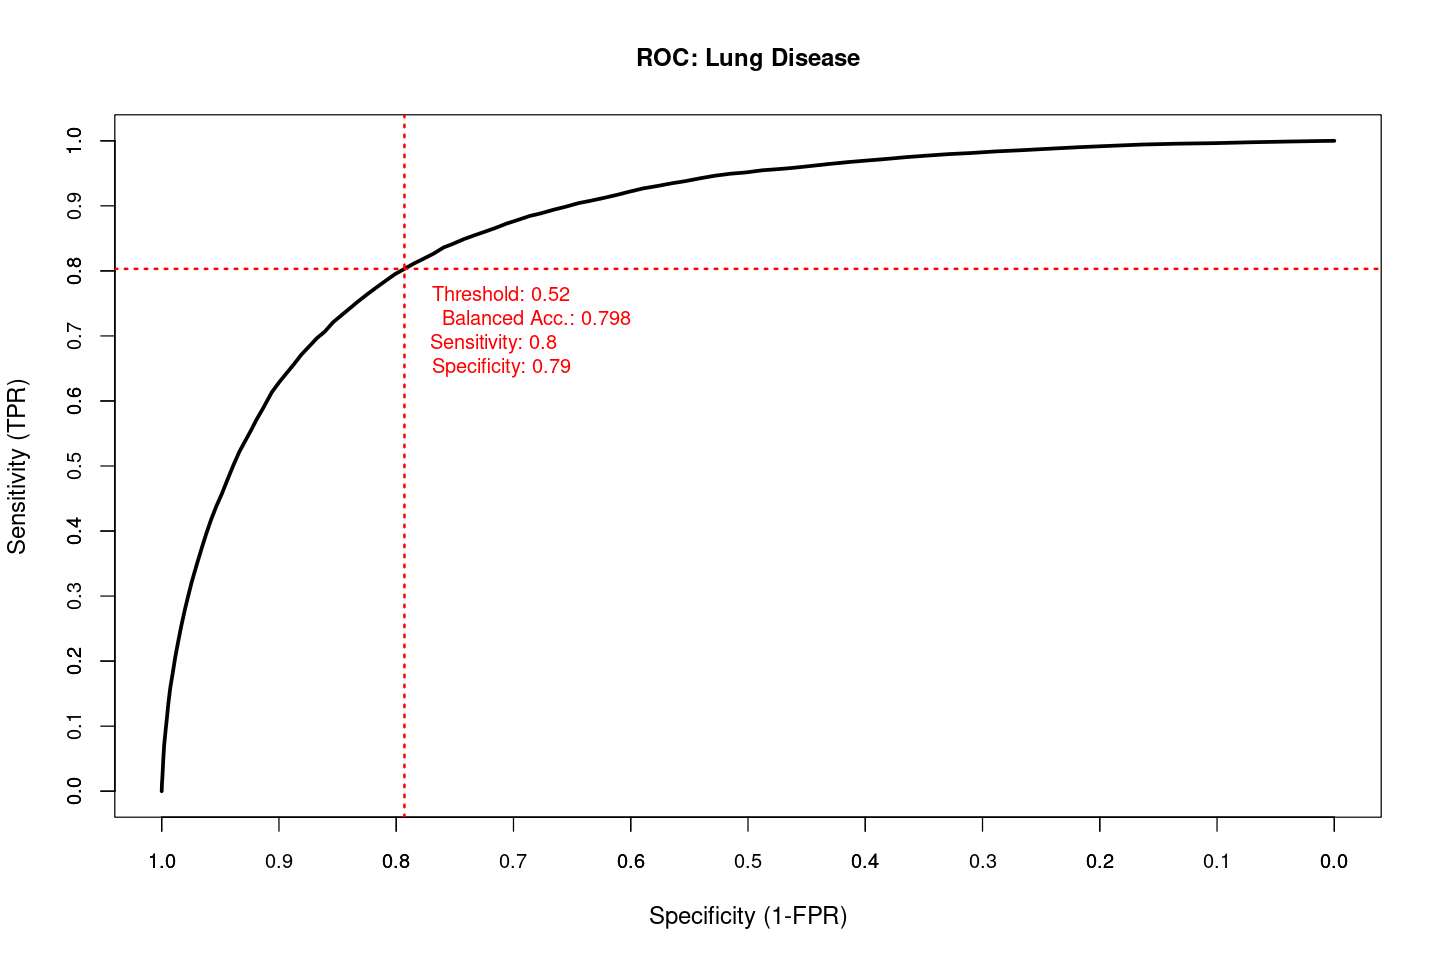

In [33]:
measures_Lung<-getTreeClassifications(myTree = rf_Lung,
                                   testDataset = test,
                                   title='Lung Disease',
                                   plot=TRUE, OUTPUT_FIELD = 'CHCCOPD2')

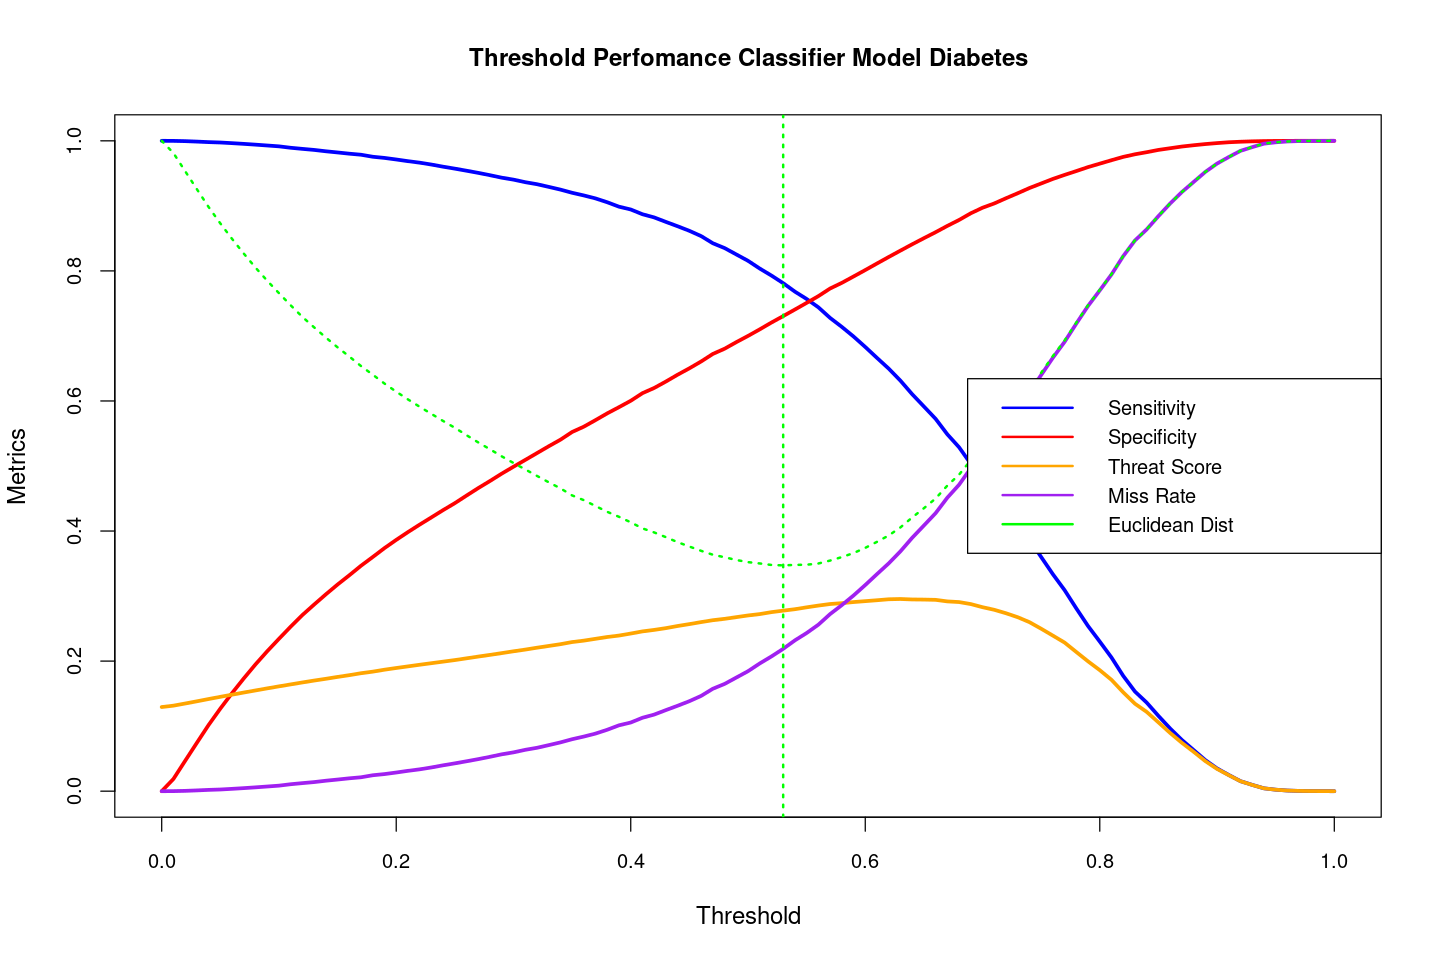

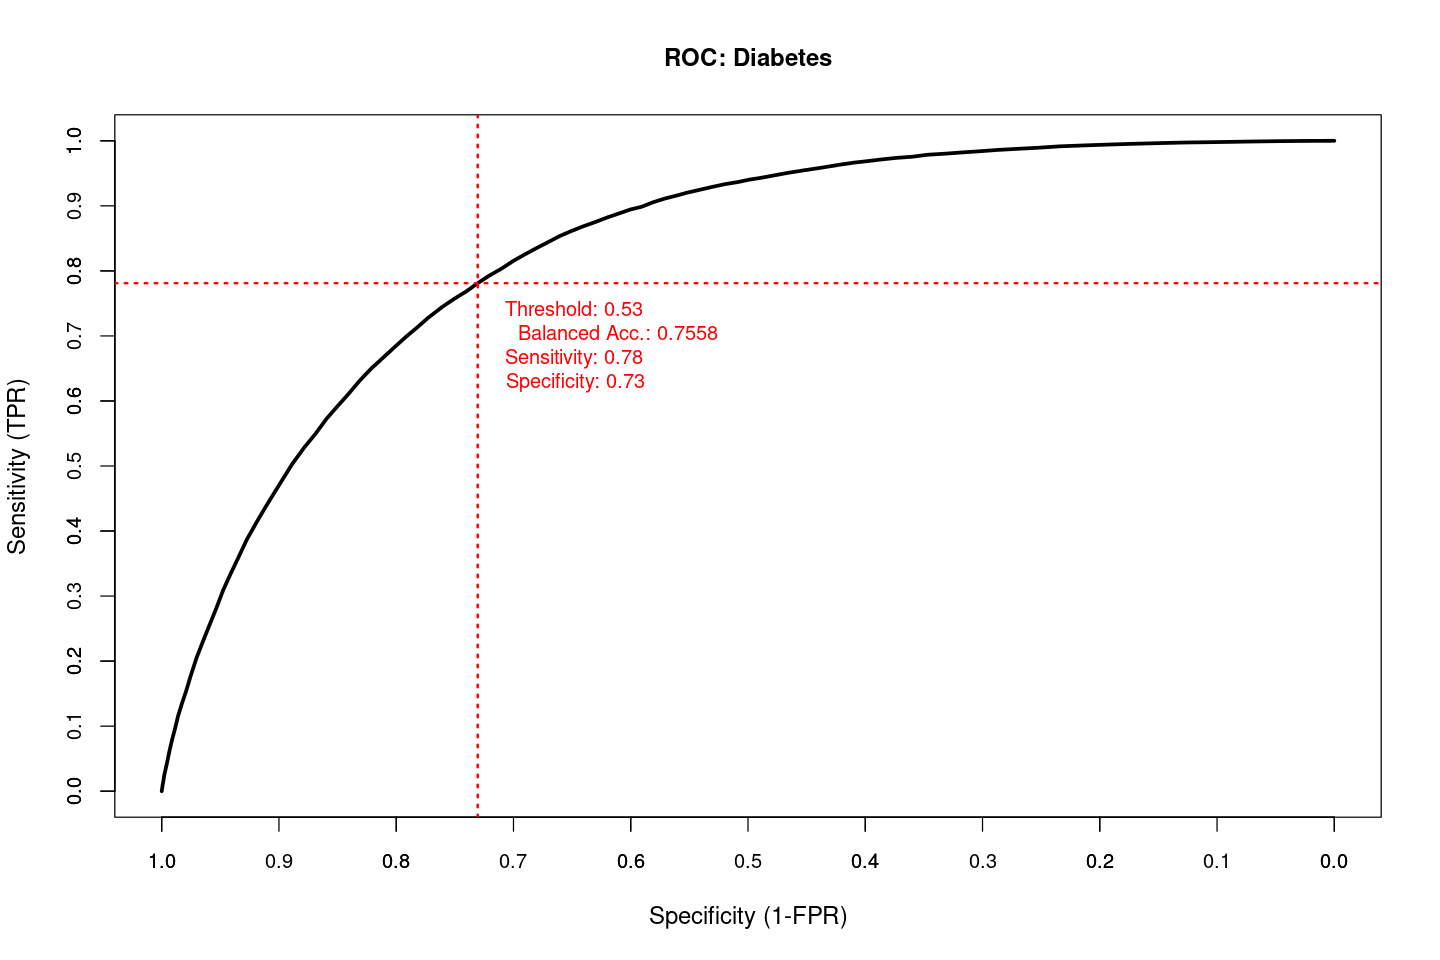

In [34]:
measures_Diabetes<-getTreeClassifications(myTree = rf_Diabetes,
                                   testDataset = test,
                                   title='Diabetes',
                                   plot=TRUE, OUTPUT_FIELD = 'DIABETE4')

## Viewing and storing final results for each disease

In [35]:
df <- data.frame(matrix(ncol = 12, nrow = 0))
df[1,] <- measures_Asthma
df[2,] <- measures_Skin
df[3,] <- measures_Heart
df[4,] <- measures_Kidney
df[5,] <- measures_Arthritis
df[6,] <- measures_Lung
df[7,] <- measures_Diabetes
df[8,] <- measures_Cancer

#print(df)
colnames(df) <- c('TP', 'FN', 'TN', 'FP', 'NPV', 'FPR', 'Sensitivity', 'Specificity', 'Miss Rate',
                  'Threat Score', 'Balanced Accuracy', 'Threshold')
rownames(df) <- c('Asthma', 'Skin Cancer', 'Heart Disease', 'Kidney Disease', 
                     'Arthritis', 'Lung Disease', 'Diabetes', 'Other Cancers')
dfnew <- subset(df, select = c('Sensitivity', 'Specificity', 'Miss Rate', 'Threat Score', 'Balanced Accuracy'))
print(dfnew)

write.csv(dfnew, file = "RF_results.csv") #store results as .csv

               Sensitivity Specificity Miss Rate Threat Score Balanced Accuracy
Asthma              0.6389      0.6747    0.3611       0.2071            0.6568
Skin Cancer         0.7658      0.7028    0.2342       0.1905            0.7343
Heart Disease       0.8071      0.7957    0.1929       0.1835            0.8014
Kidney Disease      0.7787      0.7222    0.2213       0.0940            0.7504
Arthritis           0.7492      0.7293    0.2508       0.4660            0.7392
Lung Disease        0.8031      0.7930    0.1969       0.2329            0.7980
Diabetes            0.7811      0.7305    0.2189       0.2776            0.7558
Other Cancers       0.7477      0.6730    0.2523       0.1754            0.7104


***
### Calculating importances of features for each model
***

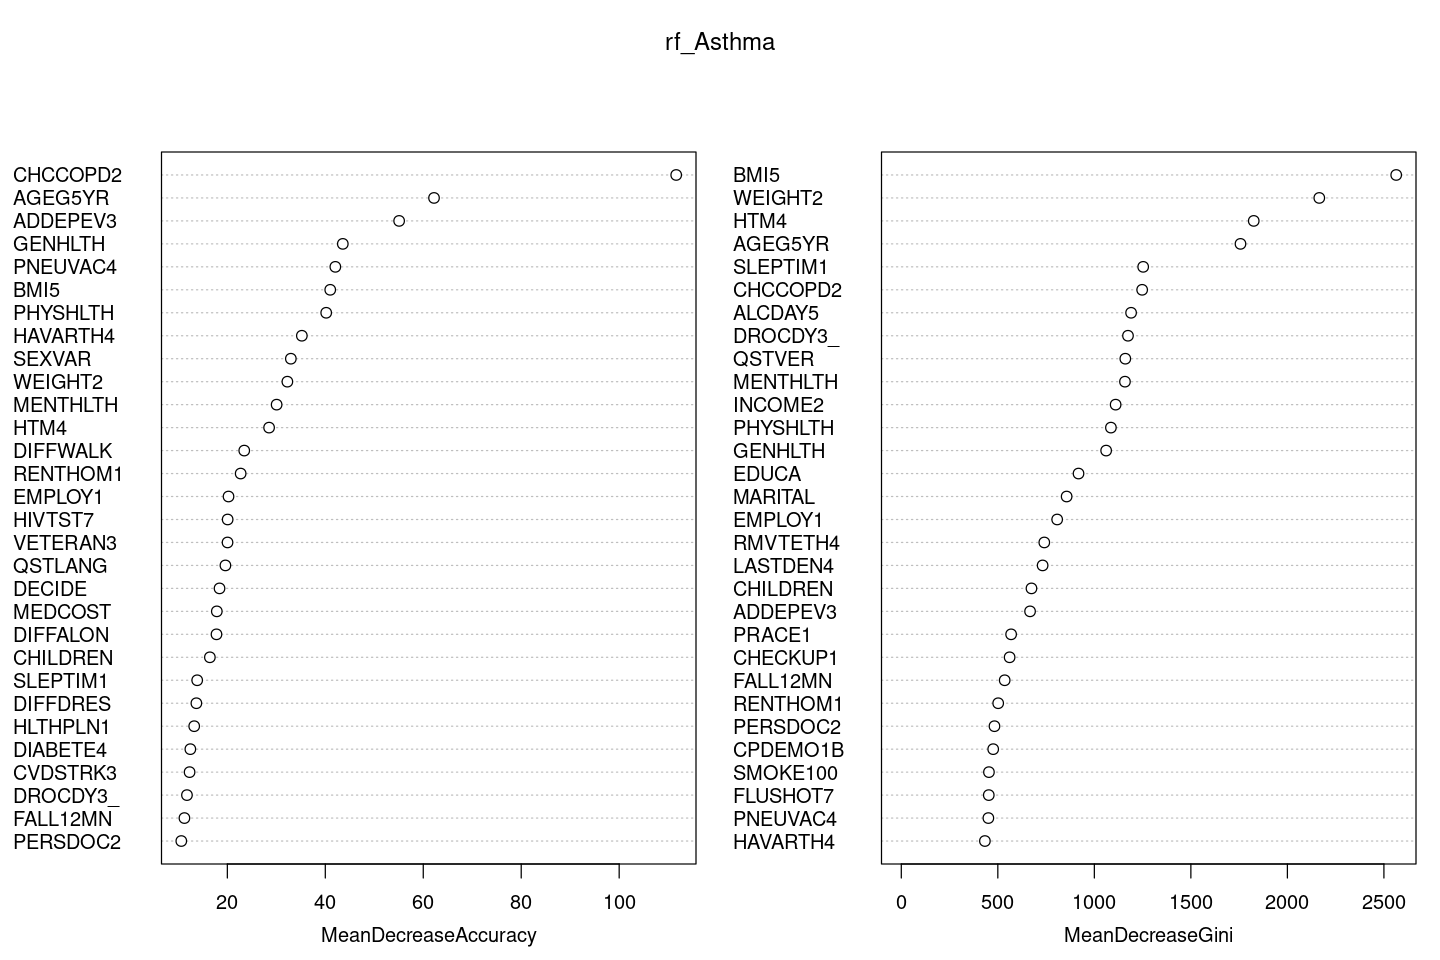

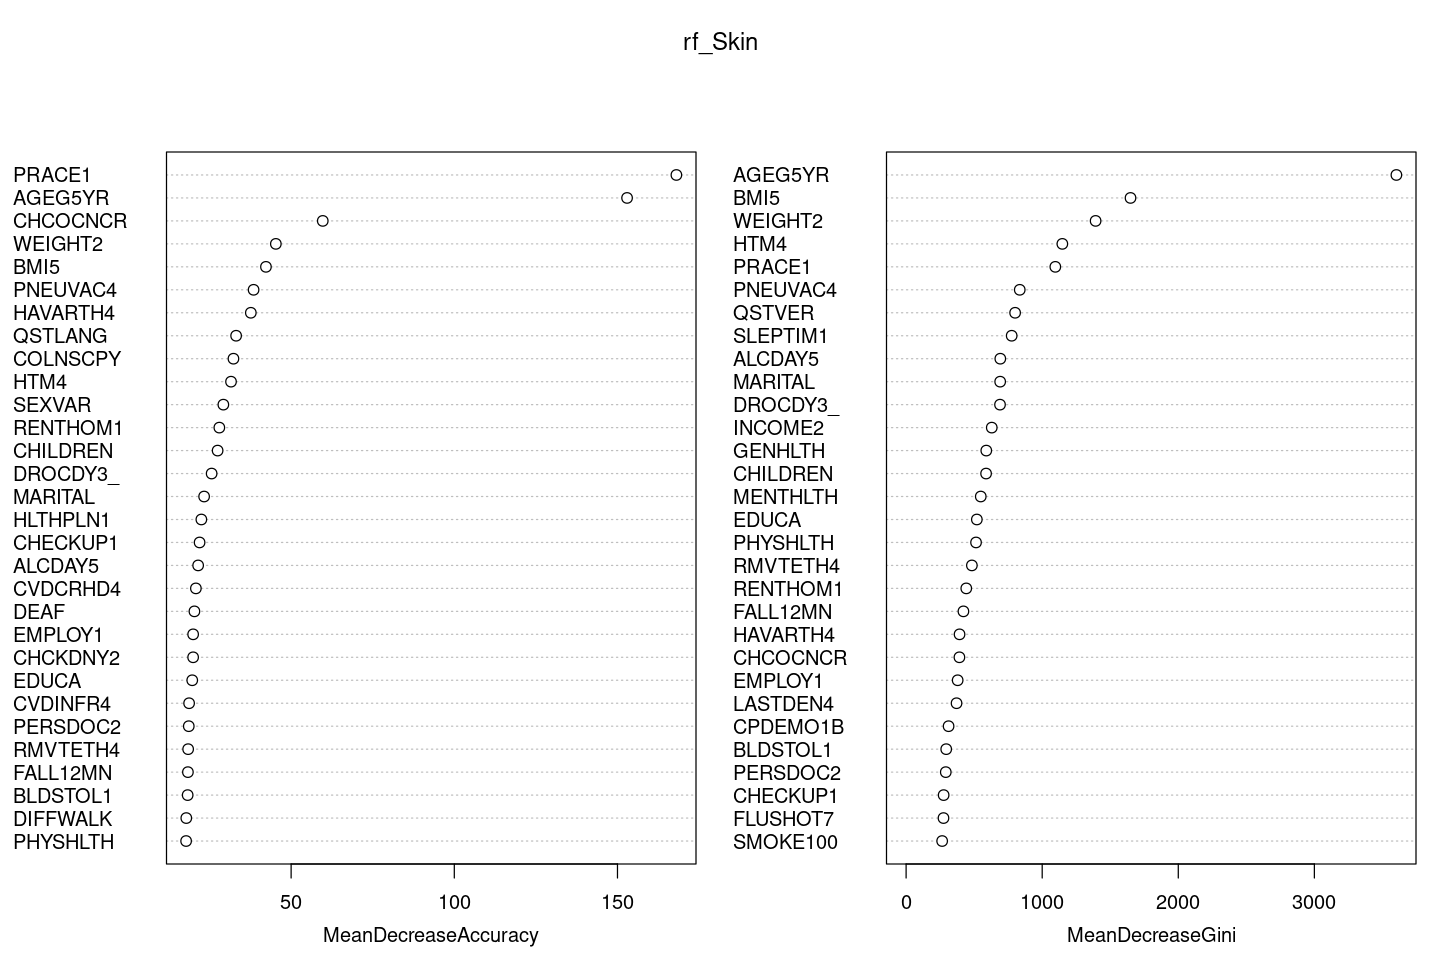

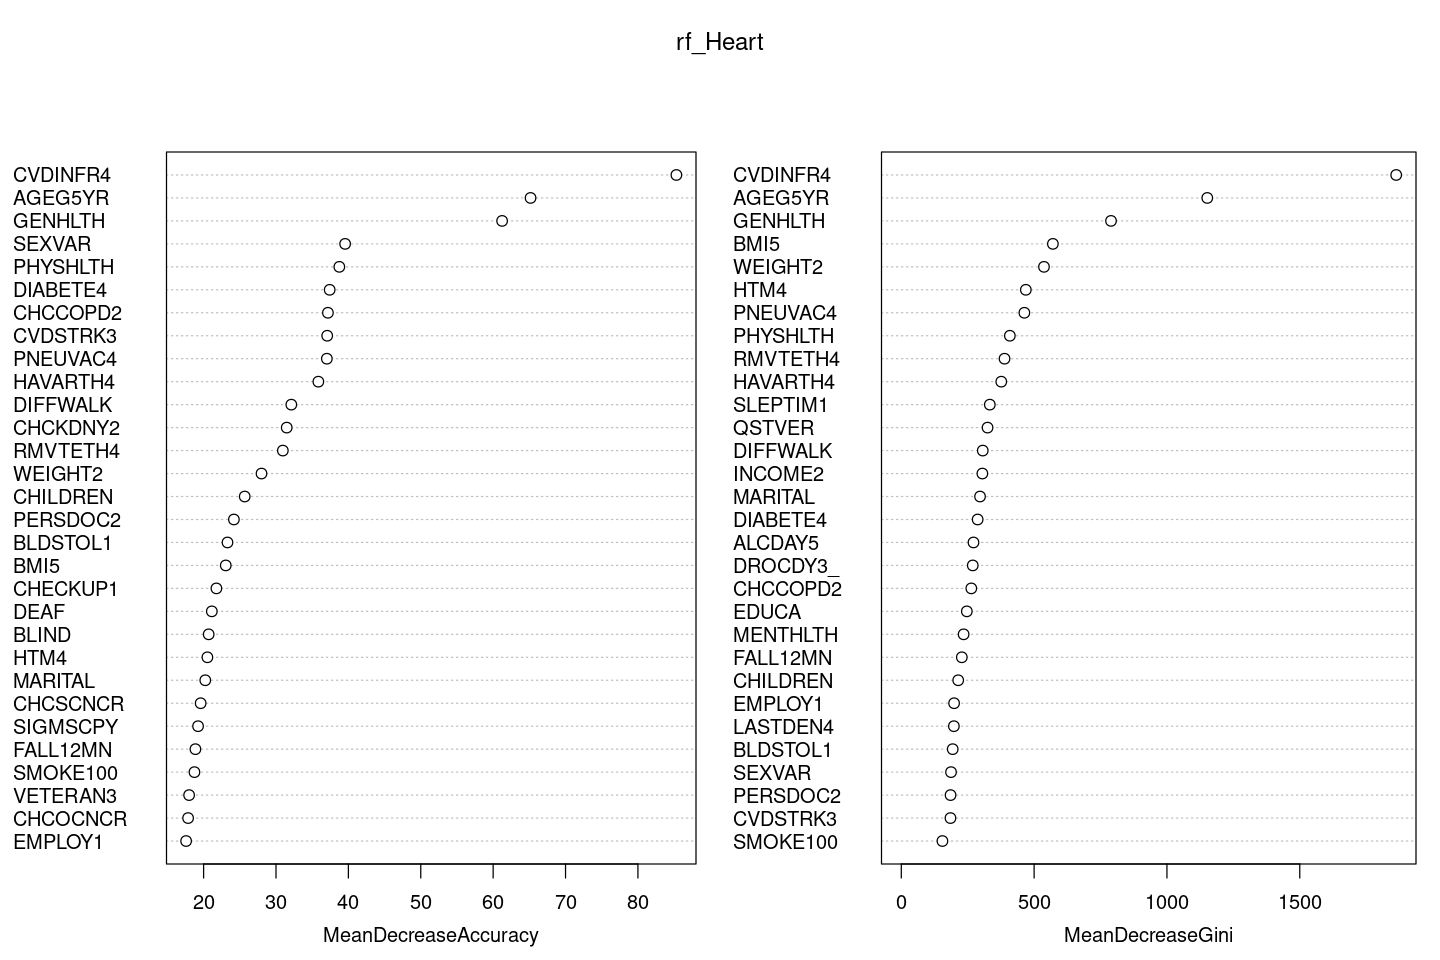

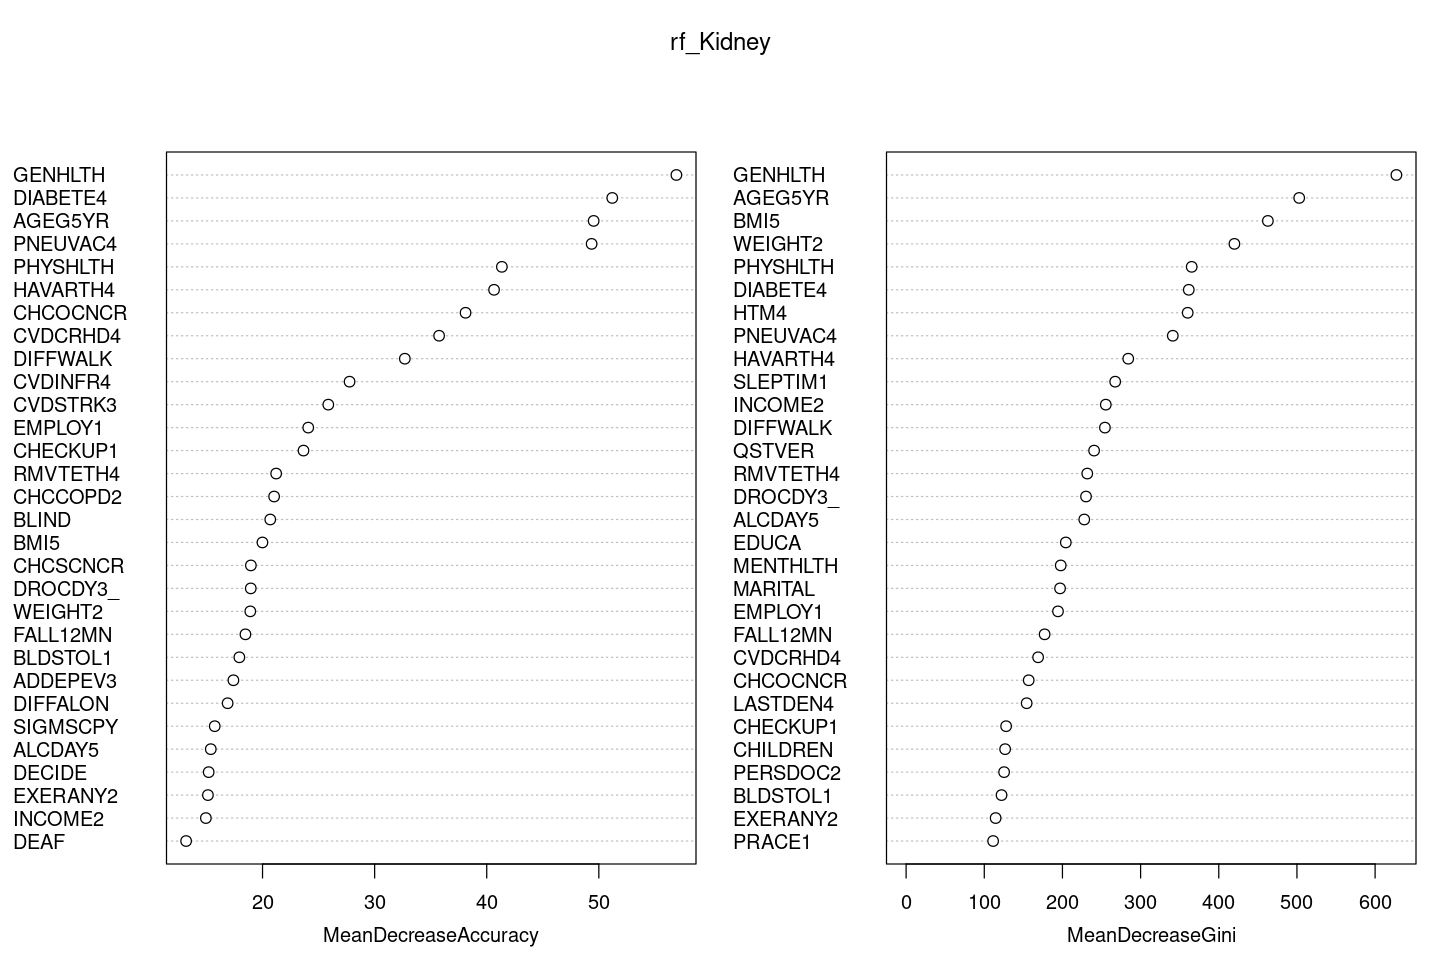

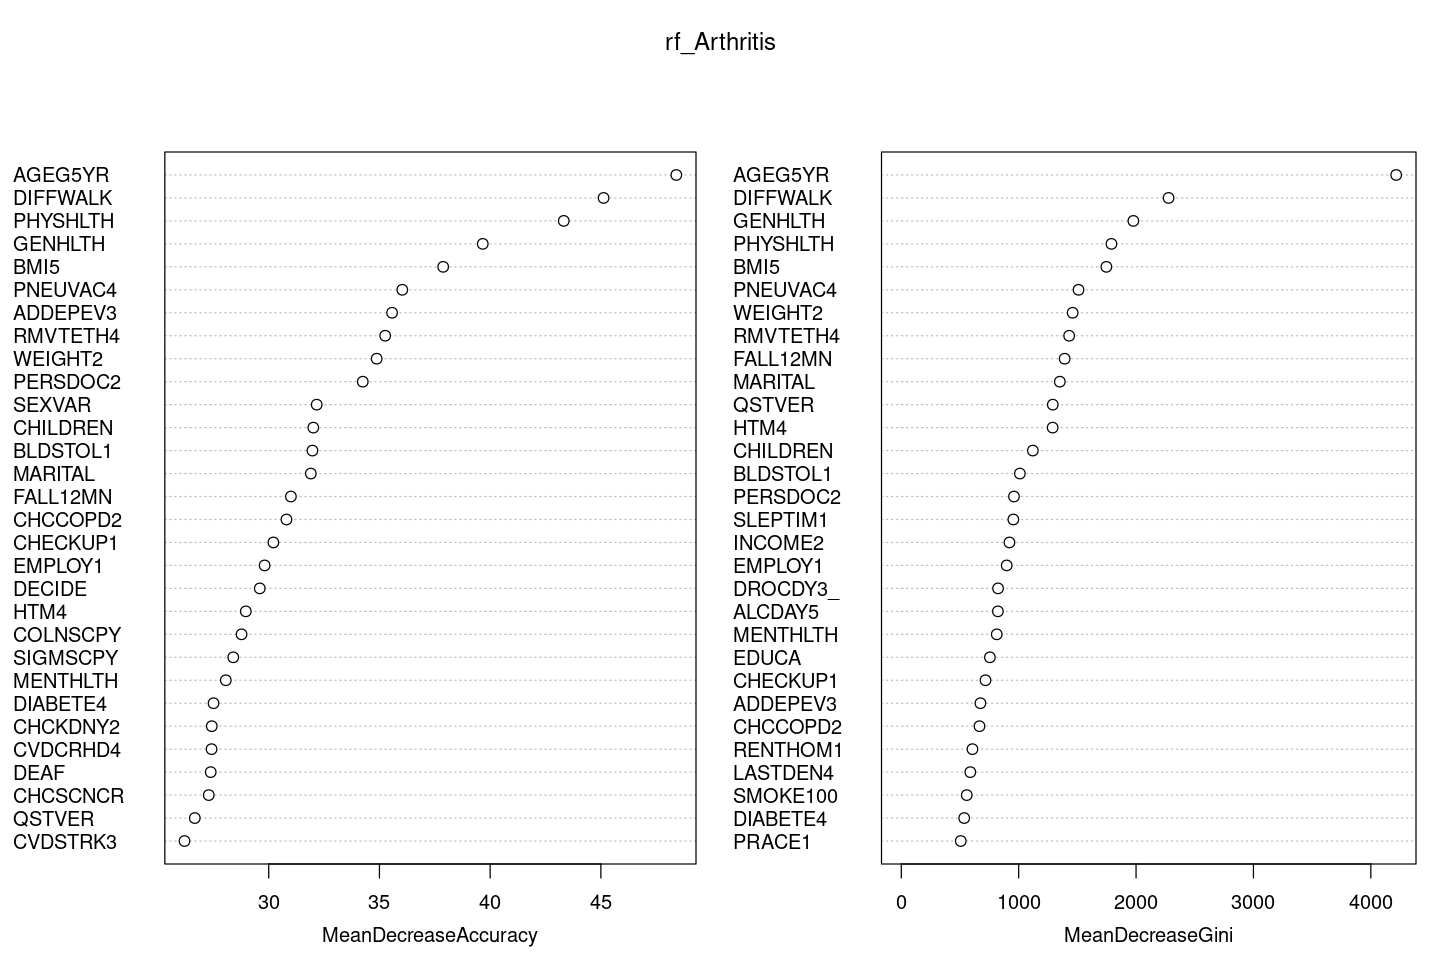

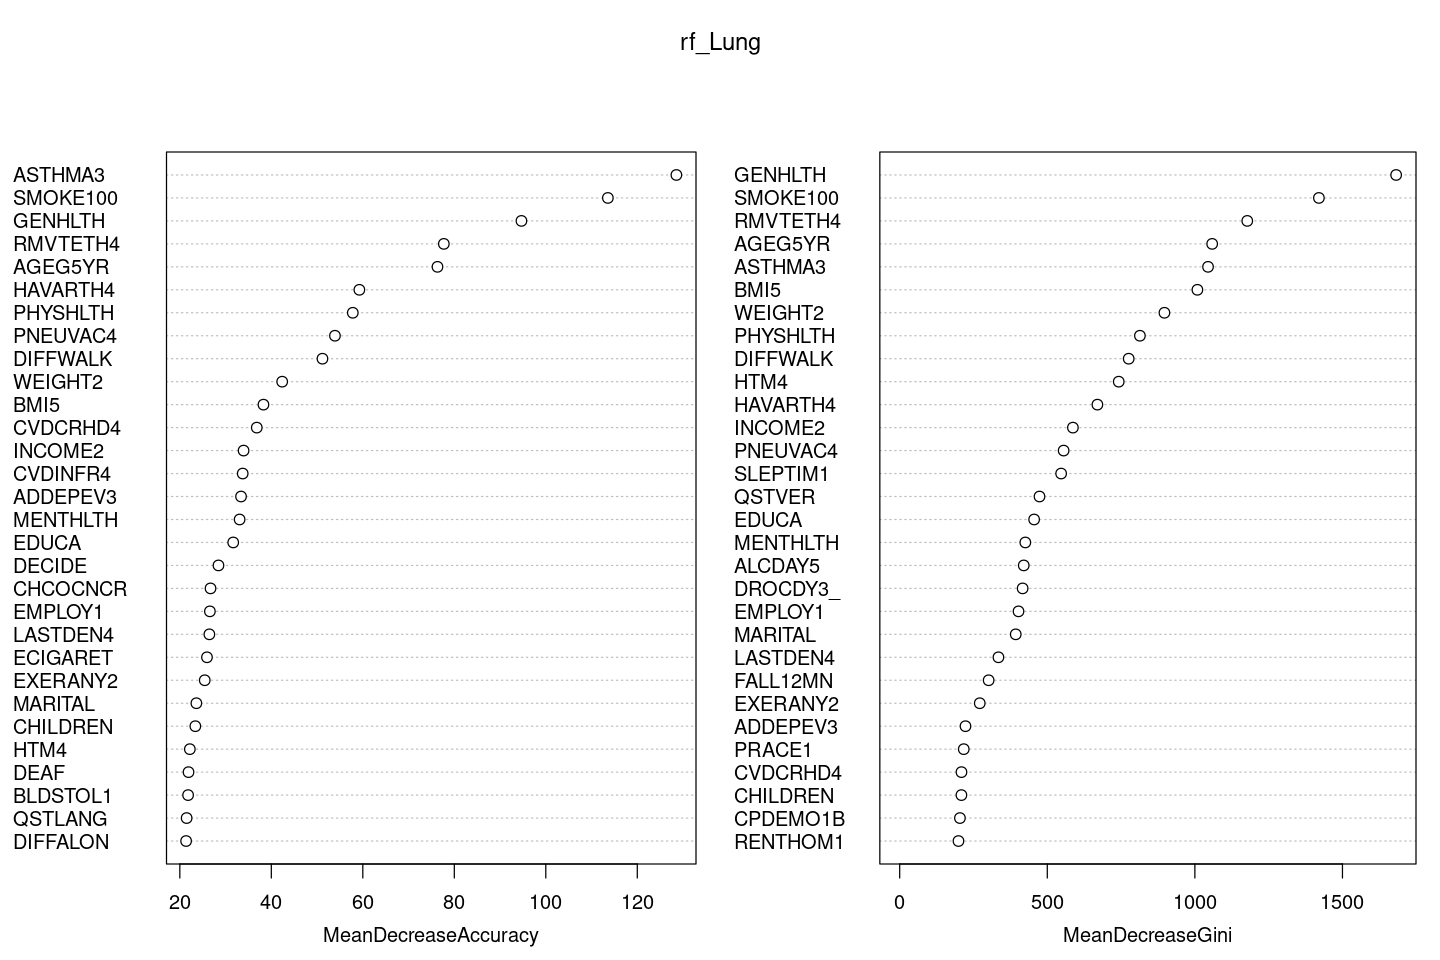

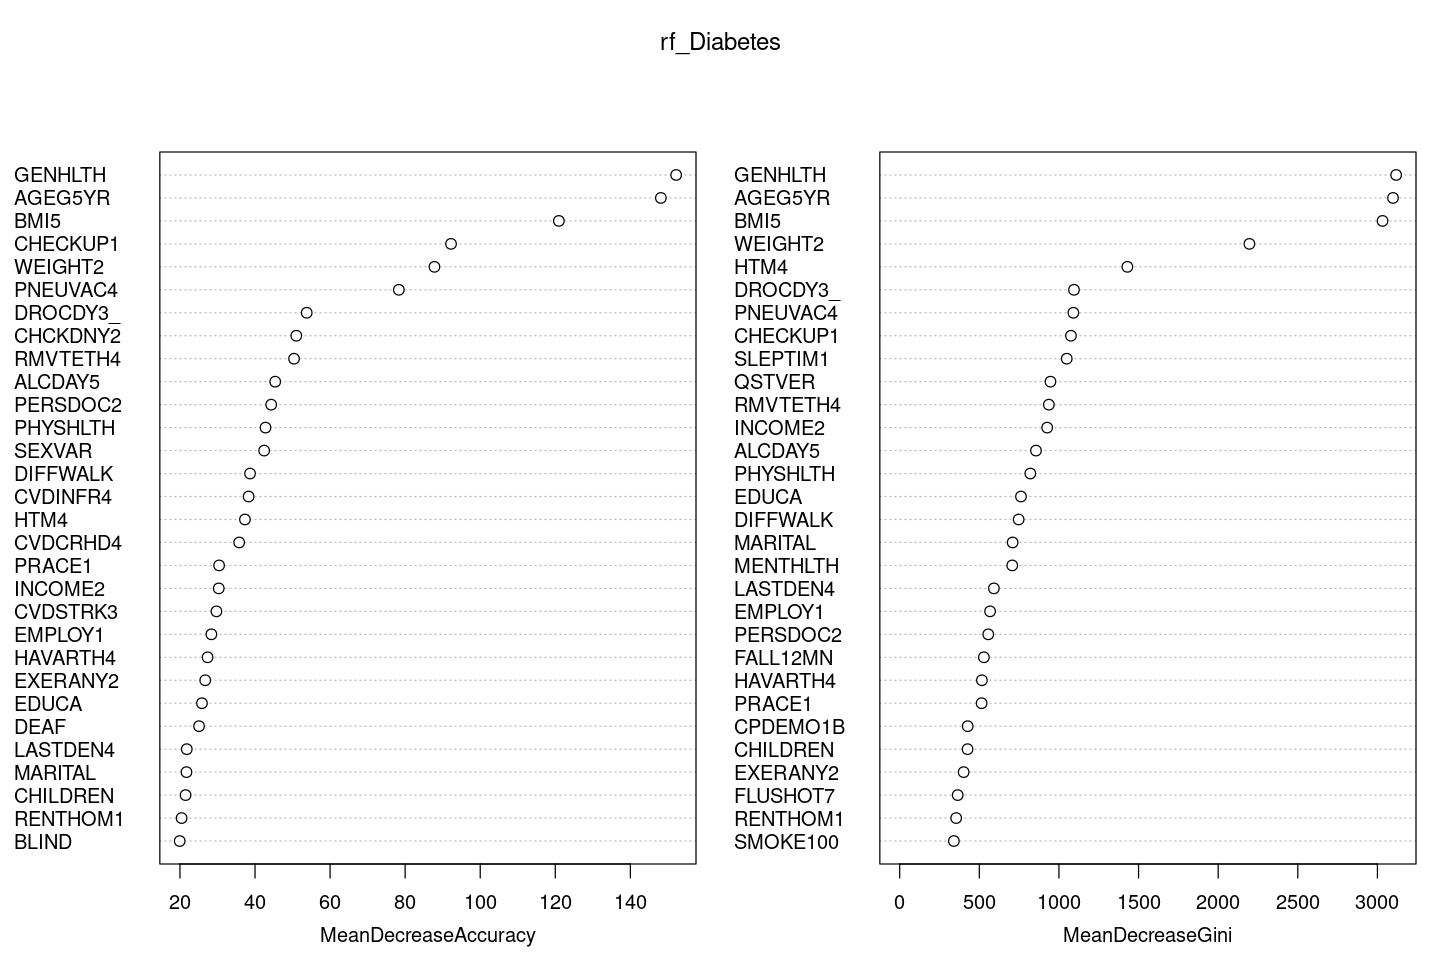

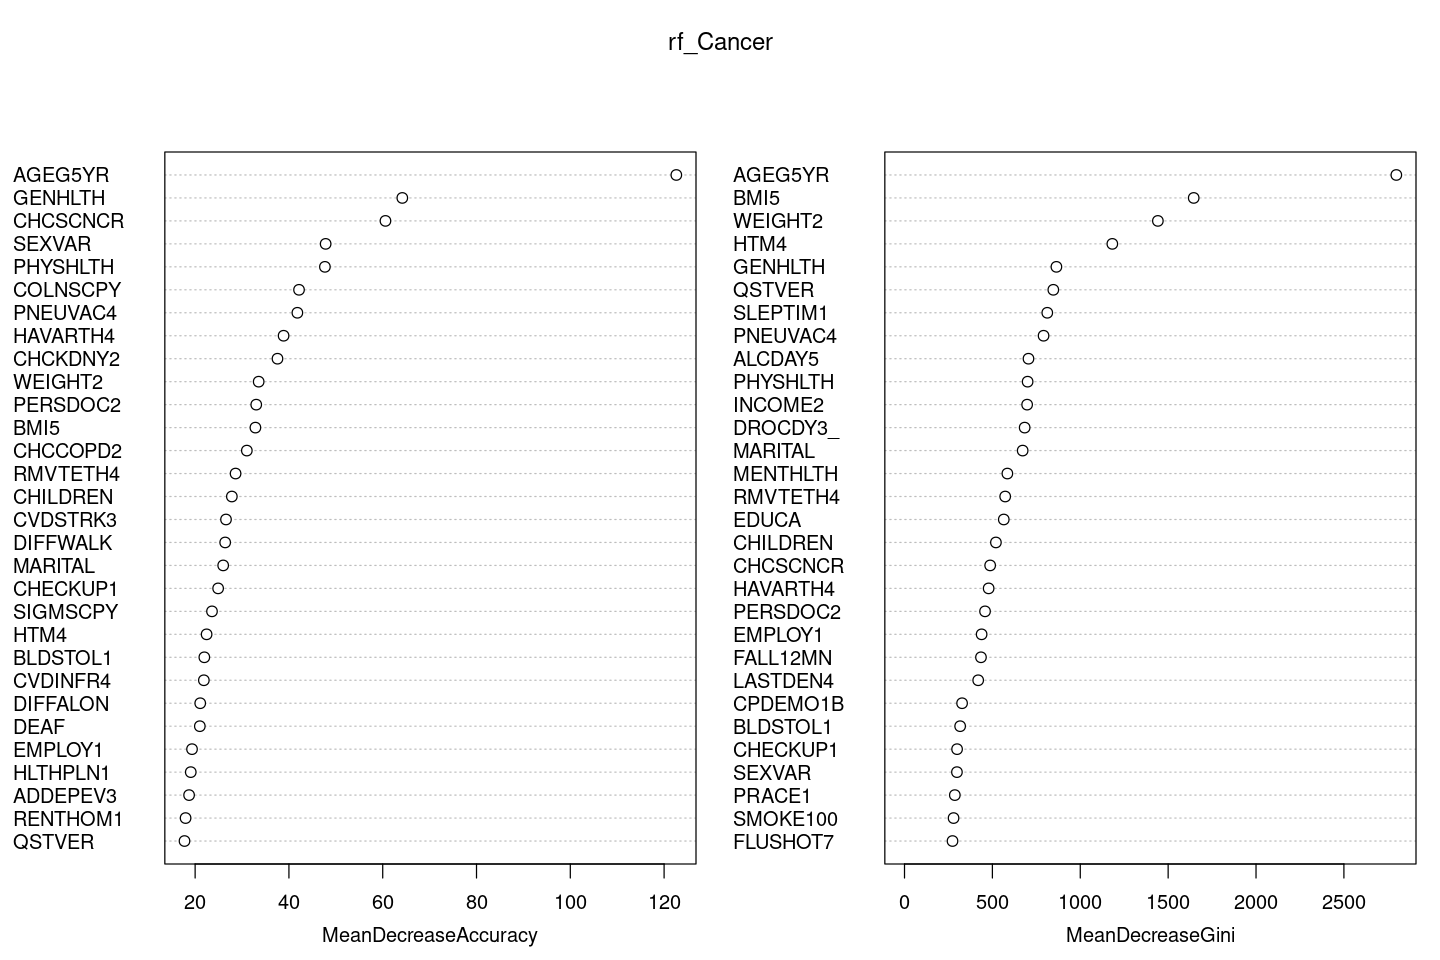

In [42]:
varImpPlot(rf_Asthma)
varImpPlot(rf_Skin)
varImpPlot(rf_Heart)
varImpPlot(rf_Kidney)
varImpPlot(rf_Arthritis)
varImpPlot(rf_Lung)
varImpPlot(rf_Diabetes)
varImpPlot(rf_Cancer)
